In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable
import datetime
import os # to save file to a selected directories, which do not need to be created
import scipy.special as ss


class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta_frechet = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta_frechet)

def PWM_GPD(excesses, k, u):
    quant_PWM_GPD = np.zeros(len(q))
    sum1, sum2 = 0, 0
    for i in range(k):
        sum1 += excesses[i]
        sum2 += i * excesses[i]
    mu0 = sum1 / k
    mu1 = sum1 / k - sum2 / k / k
    for i in range(len(q)):
        quant_PWM_GPD[i] = u + (2 * mu1 * mu0) / (mu0 - 4 * mu1) *( pow( N * (1-q[i]) / k, -(4 * mu1 - mu0) / (2 * mu1 - mu0) ) - 1 ) 
    return(quant_PWM_GPD)
             
def quantiles_GPD(excesses, k, u): 
    """ 
    we forward to function array of the quantiles as excesses, the number of excesses, k, and the border value u
    """
    quant_GPD = np.zeros(len(q)) 
    bayesian_quant_GPD = np.zeros(len(q))
    median_quant_GPD = np.zeros(800)
    all_median_quant_GPD = np.zeros(800)
    
    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate GPD quantiles and their traceplots to calculate Bayesian GPD quantiles
    traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
    traceplot_alpha = list(fit.extract().values())[0].tolist()
    traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
    beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
    alpha = np.mean(list(fit.extract().values())[0].tolist())
    gamma = 1 / alpha 
    
    for i in range(len(q)):
        quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
        for j in range(len(traceplot_gamma)):
            bayesian_quant_GPD[i] += u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
            median_quant_GPD[j] = u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
        all_median_quant_GPD = np.column_stack((all_median_quant_GPD, median_quant_GPD))
    bayesian_quant_GPD = bayesian_quant_GPD / len(traceplot_gamma)
    all_median_quant_GPD = np.delete(all_median_quant_GPD, 0, 1)
#     for j in ran?ge(len(traceplot_gamma)):
    store_medians = np.zeros(len(q))
    #taking a median of quantiles compyted in Bayesian method
    for i in range(len(q)):
        store_medians[i] = np.median(all_median_quant_GPD[:,i])
        
    list_of_params = [alpha, beta_GPD]
    return(quant_GPD, bayesian_quant_GPD, list_of_params,store_medians ) 
# it return arrays: quant_GPD, bayesian_quant_GPD and values alpha, beta_GPD

def quantiles_Fisher(excesses, k, u):
    quant_Fisher = np.zeros(len(q)) 
    bayesian_quant_Fisher = np.zeros(len(q))
    median_quant_Fisher = np.zeros(800)
    all_median_quant_Fisher = np.zeros(800)
    
    # here we fit Fisher to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate Fisher quantiles and their traceplots to calculate Bayesian Fisher quantiles
    traceplot_alpha1 = list(fit.extract().values())[0].tolist()
    traceplot_alpha2 = list(fit.extract().values())[1].tolist()
    traceplot_beta = list(fit.extract().values())[2].tolist()
    
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    beta = np.mean(list(fit.extract().values())[2].tolist())
    
    beta0 = alpha2/alpha1
    
    for i in range(len(q)):
        quant_Fisher[i] = u +  f.isf(N / k * (1 - q[i]), 2 * alpha1, 2 * alpha2, loc = 0, scale = beta / beta0)
        for j in range(len(traceplot_alpha1)):
            bayesian_quant_Fisher[i] += u + f.isf(N / k * ( 1- q[i] ), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale= ( traceplot_alpha1[j] * traceplot_beta[j]) / traceplot_alpha2[j] )
            median_quant_Fisher[j] = u + f.isf(N / k * ( 1- q[i] ), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale= ( traceplot_alpha1[j] * traceplot_beta[j]) / traceplot_alpha2[j] )
        all_median_quant_Fisher = np.column_stack((all_median_quant_Fisher, median_quant_Fisher))

    bayesian_quant_Fisher = bayesian_quant_Fisher / len(traceplot_alpha1)
    all_median_quant_Fisher = np.delete(all_median_quant_Fisher, 0, 1)

    store_medians = np.zeros(len(q))
    #taking a median of quantiles compyted in Bayesian method
    for i in range(len(q)):
        store_medians[i] = np.median(all_median_quant_Fisher[:,i])

    
    list_of_params = [alpha1, alpha2, beta]
    return(quant_Fisher, bayesian_quant_Fisher, list_of_params,traceplot_alpha1,store_medians) 
# it return arrays: quant_Fisher, bayesian_quant_Fisher and values of params as a list


In [3]:
def plot_table(k, averaged_bayesian_quant_Fisher, 
               averaged_quant_Fisher, 
               averaged_bayesian_quant_GPD, 
               averaged_quant_GPD,
               median_GPD,
               median_Fisher, 
               PWM,
               now, repetitions, nb_thresholds):
    m = "5" # how much we round
    rounding = "%." + m + "f"
    m = int(m)
    t_quantiles = PrettyTable(["# of excesses k = " +  str(k),  
                               'mean', 
                               'sd',
                               str(q[0] * 100) + "%", 
                               str(q[1] * 100) + "%",
                               str(q[2] * 100) + "%",
                               str(q[3] * 100) + "%",
                               str(q[4] * 100) + "%"])
    t_quantiles.add_row(['theoretically', '--', '--',
                         rounding % round(quant_th[0],m),  
                         rounding % round(quant_th[1], m), 
                         rounding % round(quant_th[2], m),
                         rounding % round(quant_th[3], m),
                         rounding % round(quant_th[4], m) ])
    t_quantiles.add_row(['Bayes Fisher',  '--', '--',
                         rounding % round(averaged_bayesian_quant_Fisher[0],m),  
                         rounding % round(averaged_bayesian_quant_Fisher[1], m), 
                         rounding % round(averaged_bayesian_quant_Fisher[2], m),
                         rounding % round(averaged_bayesian_quant_Fisher[3], m),
                         rounding % round(averaged_bayesian_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Fisher',  '--', '--',
                         rounding % round(averaged_quant_Fisher[0],m),  
                         rounding % round(averaged_quant_Fisher[1], m), 
                         rounding % round(averaged_quant_Fisher[2], m),
                         rounding % round(averaged_quant_Fisher[3], m),
                         rounding % round(averaged_quant_Fisher[4], m) ])
    t_quantiles.add_row(['median Fisher',  '--', '--',
                         rounding % round(median_Fisher[0],m),  
                         rounding % round(median_Fisher[1], m), 
                         rounding % round(median_Fisher[2], m),
                         rounding % round(median_Fisher[3], m),
                         rounding % round(median_Fisher[4], m) ])
    t_quantiles.add_row(['Bayes GPD', '--', '--',
                         rounding % round(averaged_bayesian_quant_GPD[0],m),  
                         rounding % round(averaged_bayesian_quant_GPD[1], m), 
                         rounding % round(averaged_bayesian_quant_GPD[2], m),
                         rounding % round(averaged_bayesian_quant_GPD[3], m),
                         rounding % round(averaged_bayesian_quant_GPD[4], m) ])
    t_quantiles.add_row(['GPD',  '--', '--',
                         rounding % round(averaged_quant_GPD[0],m),  
                         rounding % round(averaged_quant_GPD[1], m), 
                         rounding % round(averaged_quant_GPD[2], m),
                         rounding % round(averaged_quant_GPD[3], m),
                         rounding % round(averaged_quant_GPD[4], m) ])
    t_quantiles.add_row(['median GPD',  '--', '--',
                         rounding % round(median_GPD[0],m),  
                         rounding % round(median_GPD[1], m), 
                         rounding % round(median_GPD[2], m),
                         rounding % round(median_GPD[3], m),
                         rounding % round(median_GPD[4], m) ])
    t_quantiles.add_row(['PWM GPD',  '--', '--',
                         rounding % round(PWM[0],m),  
                         rounding % round(PWM[1], m), 
                         rounding % round(PWM[2], m),
                         rounding % round(PWM[3], m),
                         rounding % round(PWM[4], m) ])
    data = t_quantiles.get_string()
    # ---------------
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    with open(results_dir +   "repetitions_" + str(repetitions) + "_nb_thresholds_" + str(nb_thresholds) + '.txt', 'w') as f:
        f.write(data)
    # ---------------
    return(print(t_quantiles))

def compare_quantiles(jump_excesses, GPD, BGPD, Fisher, BFisher, median_GPD, median_Fisher, PWM,
                      theoretical_quantile,  quantile_level, now):
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + " at " + str(now.hour) + ":" + str(now.minute)
    name = " quant level: " + str(q[quantile_level])
    #------
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    name = " quant_level_" + str(q[quantile_level])
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    sample_file_name = name + '.pdf'
    fig = plt.figure()
    if not os.path.isdir(results_dir): # if the directory does not exist we create it 
        os.makedirs(results_dir)
    ax = fig.add_subplot(111)
    fig.savefig(results_dir + sample_file_name )  
    #------
    plt.hlines(y=theoretical_quantile[quantile_level], 
               xmin=min(jump_excesses), 
               xmax=max(jump_excesses), 
               color='gray', 
               zorder=1, 
               label='theoretical value')

    plt.plot(jump_excesses, GPD[quantile_level,:],  'deepskyblue', label='GPD')
    plt.plot(jump_excesses, BGPD[quantile_level,:], 'darkblue', label='BGPD') 
    plt.plot(jump_excesses, median_GPD[quantile_level,:], 'aqua', label='median GPD')
    plt.plot(jump_excesses, Fisher[quantile_level,:], 'red', label='Fisher') 
    plt.plot(jump_excesses, BFisher[quantile_level,:], 'darkred', label='BFisher') 
    plt.plot(jump_excesses, median_Fisher[quantile_level,:], 'coral', label='median Fisher')
    plt.plot(jump_excesses, PWM[quantile_level,:], 'lime', label='PWM GPD')

    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[quantile_level]))
    plt.title('Variability of quantile at level ' + str(q[quantile_level])  )
    plt.legend()
    plt.savefig(results_dir + sample_file_name)
    return(plt.show())

def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [4]:
n = 10 # number of sampled dataset over which we average the quantiles
N = 1000

r = frechet.rvs(beta_frechet, size=N)
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta_frechet, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [5]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  } 
}
data { 
  int N;
  real y[N];
}
parameters { 
  real<lower = 0> alpha;
  real<lower = 0> beta; // we set the bounderies for the computational facility
}
model {
// Priors here to be defined; no priors - we assume improper priors on params
//  alpha ~ gamma(1,1);
//  beta ~ gamma(1,1);

  target += -log(alpha + 1) - 1/2 * (log(alpha) + log(alpha + 2)); 
  target += log(1/beta);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }
}
generated quantities{}
"""

Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
}
data { 
  int N;
  real y[N]; 
}
parameters { 
  //parameters of the Fisher
  real<lower=1> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta; 
}

model {
  // when we deliberately do not specify priors then Stan works with improper priors

  //alpha1 ~ gamma(10,10);
  target += - 2 * log(alpha1);
  target += -log(alpha2 + 1) - 1/2 * (log(alpha2) + log(alpha2 + 2));
  target += log(1/beta);

// Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}
generated quantities{}
"""

In [6]:
how_many_different_thresholds = 5
min_thresholds = 100
max_thresholds = 500

# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

number_of_GPD_params = 2
number_of_Fisher_params = 3

averaged_params_GPD, averaged_params_Fisher =  np.zeros(number_of_GPD_params), np.zeros(number_of_Fisher_params)

now = datetime.datetime.now() # we take it globally to save all the tables and plots in one directory

# we initialize the matrices of quantiles with row of zeros, we need it to plot
concatenated_averaged_quant_GPD, concatenated_averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_quant_Fisher, concatenated_averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))
concatenated_median_quant_BFisher, concatenated_median_quant_BGPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_probability_weighted_moments_GPD = np.zeros(len(q))
probability_weighted_moments_GPD = np.zeros(len(q))

bank_params_Fisher = np.zeros(number_of_Fisher_params)
bank_alpha1_traceplots = np.zeros(800)

super_concatenated_probability_weighted_moments_GPD = np.zeros(len(q))
super_concatenated_quant_GPD = np.zeros(len(q))
super_concatenated_bayesian_quant_GPD = np.zeros(len(q))
super_concatenated_quant_Fisher = np.zeros(len(q))
super_concatenated_bayesian_quant_Fisher = np.zeros(len(q))
super_concatenated_median_quant_BFisher = np.zeros(len(q))
super_concatenated_median_quant_BGPD = np.zeros(len(q))
bank_medians_GPD = np.zeros(len(q))
bank_medians_Fisher = np.zeros(len(q))


In [7]:
for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    
    # in data frechet we keep the matrix of excesses
    # transferred r is a matrix with n sampled dataset from Frechet
    
    data_frechet, u = k_greatest_values_matrices(r,k) 

    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)

    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 

    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
    
    # we create matrices which we will reinitialize after each change of thresholds
    # from them we will calculate quantiles 
    
    # error - 1st: we don't keep track of all the values for each threshold, 2nd these values should be returned from quantile functions
    
    averaged_probability_weighted_moments_GPD = np.zeros(len(q))
    averaged_quant_GPD, averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
    averaged_quant_Fisher, averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))
    averaged_medians_GPD, averaged_medians_Fisher = np.zeros(len(q)), np.zeros(len(q))
    
    for i in range(n): 
        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] 
        quant_GPD, bayesian_quant_GPD, params_GPD, medians_GPD = quantiles_GPD(excesses_array, k, u[i])
        quant_Fisher, bayesian_quant_Fisher, params_Fisher, trace_alpha1, medians_Fisher = quantiles_Fisher(excesses_array, k, u[i])
        probability_weighted_moments_GPD = PWM_GPD(excesses_array, k, u[i])
        print("medians_GPD = ", medians_GPD, "\n medians_Fisher = ", medians_Fisher )
        
        averaged_medians_GPD += medians_GPD
        averaged_medians_Fisher += medians_Fisher
        
        averaged_quant_GPD += quant_GPD
        averaged_bayesian_quant_GPD += bayesian_quant_GPD
        averaged_params_GPD += params_GPD 
        averaged_probability_weighted_moments_GPD += probability_weighted_moments_GPD
        
        averaged_quant_Fisher += quant_Fisher
        averaged_bayesian_quant_Fisher += bayesian_quant_Fisher

        bank_params_Fisher = np.column_stack((bank_params_Fisher, params_Fisher))
        bank_alpha1_traceplots = np.column_stack((bank_alpha1_traceplots, trace_alpha1))

        # we save the values of the estimated quantiels for each replication of threshold 
        bank_medians_GPD = np.column_stack((bank_medians_GPD, medians_GPD))
        bank_medians_Fisher = np.column_stack((bank_medians_Fisher, medians_Fisher))

        averaged_params_Fisher += params_Fisher 
        
        super_concatenated_probability_weighted_moments_GPD = np.column_stack((super_concatenated_probability_weighted_moments_GPD, probability_weighted_moments_GPD))
        super_concatenated_quant_GPD = np.column_stack( (super_concatenated_quant_GPD, quant_GPD ) )
        super_concatenated_bayesian_quant_GPD = np.column_stack( (super_concatenated_bayesian_quant_GPD, bayesian_quant_GPD ) )
        super_concatenated_quant_Fisher = np.column_stack( (super_concatenated_quant_Fisher, quant_Fisher ) )
        super_concatenated_bayesian_quant_Fisher = np.column_stack( (super_concatenated_bayesian_quant_Fisher, bayesian_quant_Fisher ) )

    # saving median quantiles to forward it to the table
    
    averaged_quant_GPD = averaged_quant_GPD / n 
    averaged_bayesian_quant_GPD = averaged_bayesian_quant_GPD / n
    averaged_params_GPD = asarray(averaged_params_GPD) / n
    averaged_probability_weighted_moments_GPD = averaged_probability_weighted_moments_GPD / n
    
    averaged_medians_GPD = averaged_medians_GPD / n
    averaged_medians_Fisher = averaged_medians_Fisher / n
    
    averaged_quant_Fisher = averaged_quant_Fisher / n 
    averaged_bayesian_quant_Fisher = averaged_bayesian_quant_Fisher / n
    averaged_params_Fisher = asarray(averaged_params_Fisher) / n
    

    plot_table(jump_excesses[j], 
           averaged_bayesian_quant_Fisher, 
           averaged_quant_Fisher, 
           averaged_bayesian_quant_GPD, 
           averaged_quant_GPD,
           averaged_medians_GPD,
           averaged_medians_Fisher,
           averaged_probability_weighted_moments_GPD, 
           now, n, how_many_different_thresholds)
    
    print(" Current number of excesses k = " + str(jump_excesses[j]), 
          "\n", "averaged_params_GPD: ", averaged_params_GPD, 
          "\n", "averaged_params_Fisher: ", averaged_params_Fisher)    
    
    #preparing to plot
    concatenated_averaged_probability_weighted_moments_GPD= np.column_stack((concatenated_averaged_probability_weighted_moments_GPD, averaged_probability_weighted_moments_GPD))
    concatenated_averaged_quant_GPD = np.column_stack( (concatenated_averaged_quant_GPD, averaged_quant_GPD ) )
    concatenated_averaged_bayesian_quant_GPD = np.column_stack( (concatenated_averaged_bayesian_quant_GPD, averaged_bayesian_quant_GPD ) )
    concatenated_averaged_quant_Fisher = np.column_stack( (concatenated_averaged_quant_Fisher, averaged_quant_Fisher ) )
    concatenated_averaged_bayesian_quant_Fisher = np.column_stack( (concatenated_averaged_bayesian_quant_Fisher, averaged_bayesian_quant_Fisher ) )
    concatenated_median_quant_BFisher = np.column_stack( (concatenated_median_quant_BFisher, averaged_medians_Fisher ) )
    concatenated_median_quant_BGPD = np.column_stack( (concatenated_median_quant_BGPD, averaged_medians_GPD ) )
    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 3.21847085  9.81771604  9.81771604  9.81771604 16.36918776] 
 medians_Fisher =  [ 8.77502007 11.12761021 13.47082748 18.90709155 21.24718453]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [3.18990813 3.18990813 3.18990813 3.18990813 3.18990813] 
 medians_Fisher =  [ 6.45904392  7.85860449  9.24011155 12.42636784 13.80769282]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.94505373 11.11998028 15.07980593 29.35516172 38.41185069] 
 medians_Fisher =  [ 7.84524631 11.00790034 15.20188452 31.16655497 42.16175526]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.67442931  9.23656965 12.67622461 26.25571384 35.91706768] 
 medians_Fisher =  [ 6.56682459  9.11925226 12.84951042 29.87380204 43.42662251]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.33490961  8.68204866 11.77962831 23.8272841  32.29592734] 
 medians_Fisher =  [ 6.17886965  8.50207316 11.80345332 26.45809664 37.32621841]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 3.10408022  3.10408022  3.10408022 17.32892747 17.32892747] 
 medians_Fisher =  [ 6.7297303   8.92723933 11.69199021 21.28099542 27.36801155]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.37409576  8.53691312 11.28363765 20.62834747 26.45470048] 
 medians_Fisher =  [ 6.23462861  8.40238477 11.24195813 21.96755995 29.28198011]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [  7.06753267  11.5700568   20.1514923   80.72651491 150.84649857] 
 medians_Fisher =  [  6.97431104  11.8321404   21.87322036 106.25730726 214.83523497]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.25298725 11.11069919 17.08820814 48.08518006 76.12111909] 
 medians_Fisher =  [ 7.1288929  11.05613126 17.64481793 55.7717564  93.60869998]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 3.23393246  3.23393246  3.23393246  3.23393246 19.43836099] 
 medians_Fisher =  [ 6.96350869  9.38292198 12.5264505  24.50572792 32.86054792]
+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 100 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.03844 | 9.94609  | 14.49308 | 43.35505 | 79.48841 |
|         Fisher        |  --  | -- | 7.27374 | 10.04160 | 14.01050 | 33.74077 | 52.47641 |
|     median Fisher     |  --  | -- | 6.98561 | 9.72163  | 13.75442 | 34.86153 | 55.59239 |
|       Bayes GPD       |  --  | -- | 5.81537 | 8.39427  | 11.62104 | 31.65376 | 53.54670 |
|          GPD          |  --  | -- | 5.46082 | 7.93698  | 10.62166 | 26.08003 | 38.46835 |
|       media

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.34189461 10.03489751 13.535696   26.38198995 34.85287715] 
 medians_Fisher =  [ 7.37160417 10.14418484 13.79723114 27.78994614 37.13768038]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.83096566  8.94808911 11.5963947  20.3939653  25.81537625] 
 medians_Fisher =  [ 6.767071    9.01603458 11.89096635 21.84223174 28.29077108]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.72540305 11.02401908 15.64922242 35.29049262 49.61218813] 
 medians_Fisher =  [ 7.65752588 11.17272436 16.35199476 38.99016068 56.91503345]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.65652935  9.07029207 12.23104965 24.21495799 32.41287296] 
 medians_Fisher =  [ 6.61569811  9.01753889 12.32448658 25.19368402 34.37108981]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.26075383  8.5044254  11.65240882 23.91944615 32.78645027] 
 medians_Fisher =  [ 6.18007443  8.55404924 11.87229248 25.97908271 36.48028391]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.71937607  8.99023681 11.94090058 22.40197693 29.20749435] 
 medians_Fisher =  [ 6.71287726  9.15671002 12.43642377 24.77846752 33.24378056]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.28342827  8.38821962 11.0016605  20.43628161 26.33483976] 
 medians_Fisher =  [ 6.19694774  8.41357963 11.34034811 22.52782509 30.11837384]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.52413804 11.25004123 16.73437679 43.10133954 64.93970946] 
 medians_Fisher =  [ 7.34605711 11.28346281 17.57633692 51.75922476 82.95379577]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.32382485 10.80765874 15.99238174 39.70703952 58.64810977] 
 medians_Fisher =  [ 7.32816213 11.09318512 16.87752426 45.995865   71.64016016]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.06389489  9.42587518 12.36830937 22.67846958 29.04127864] 
 medians_Fisher =  [ 6.98259351  9.33354471 12.30471862 22.89070286 29.76465886]
+-----------------------+------+----+---------+---------+----------+----------+----------+
| # of excesses k = 200 | mean | sd |  98.0%  |  99.0%  |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+---------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493 | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 6.99308 | 9.93195 | 14.21900 | 34.15040 | 50.94538 |
|         Fisher        |  --  | -- | 6.98214 | 9.75065 | 13.63112 | 30.09304 | 42.69970 |
|     median Fisher     |  --  | -- | 6.91586 | 9.71850 | 13.67723 | 30.77472 | 44.09156 |
|       Bayes GPD       |  --  | -- | 7.02255 | 9.80634 | 13.69070 | 30.15314 | 42.83101 |
|          GPD          |  --  | -- | 6.93968 | 9.51621 | 12.97605 | 26.50691 | 36.12439 |
|       median GPD    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.35352984 10.30141931 14.29583385 30.7031791  42.53921408] 
 medians_Fisher =  [ 7.39701705 10.58194629 15.07863121 33.76047425 47.80287889]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.89687676  9.34552292 12.5617163  24.41413514 32.23071841] 
 medians_Fisher =  [ 6.87677032  9.43076817 12.74645824 25.38686215 34.04709098]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.62512067 10.99133594 15.83328015 36.74198917 52.40185964] 
 medians_Fisher =  [ 7.60599747 11.16829092 16.33541374 40.36597018 59.62920059]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.67392584  8.84145328 11.58351794 20.97142533 26.83798163] 
 medians_Fisher =  [ 6.65223233  9.14466282 12.49923616 25.78610812 35.04455218]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.32130096  8.37473285 11.00445949 20.32741145 26.21667358] 
 medians_Fisher =  [ 6.29170884  8.3419143  10.97115313 20.4594465  26.59198654]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.67430395  9.07214485 12.30334976 24.32710553 32.64364539] 
 medians_Fisher =  [ 6.6692652   9.17338871 12.58563519 26.16340528 36.1454025 ]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.31624191  8.3796656  11.01325514 20.30061214 26.17463454] 
 medians_Fisher =  [ 6.26590465  8.43019066 11.25289548 21.57743862 28.2763221 ]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.56812376 11.04841424 16.12823864 38.96430113 56.55614129] 
 medians_Fisher =  [ 7.58490231 11.3994667  17.28070614 46.30139282 70.98026835]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.3194654  10.71310975 15.69128488 37.75410499 55.00595715] 
 medians_Fisher =  [ 7.27878522 10.78813122 16.0178314  41.37244206 62.05031611]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.017111    9.35514902 12.24791032 22.17218628 28.30596909] 
 medians_Fisher =  [ 7.00515809  9.41215194 12.53554828 23.67464853 30.84116535]
+-----------------------+------+----+---------+---------+----------+----------+----------+
| # of excesses k = 300 | mean | sd |  98.0%  |  99.0%  |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+---------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493 | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.03894 | 9.97307 | 14.17231 | 32.70883 | 47.42842 |
|         Fisher        |  --  | -- | 7.01120 | 9.80253 | 13.68585 | 29.78629 | 41.77866 |
|     median Fisher     |  --  | -- | 6.96277 | 9.78709 | 13.73035 | 30.48482 | 43.14092 |
|       Bayes GPD       |  --  | -- | 7.04180 | 9.81470 | 13.64511 | 29.44922 | 41.25562 |
|          GPD          |  --  | -- | 6.95118 | 9.57734 | 13.11971 | 26.99670 | 36.82408 |
|       median GPD    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.28413731 10.16702294 14.10271436 29.76692068 40.88633589] 
 medians_Fisher =  [ 7.3926312  10.6114576  15.15409216 34.44900351 49.01037125]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.78439985  9.06662669 11.9939532  22.34324947 28.92623944] 
 medians_Fisher =  [ 6.86366921  9.35580991 12.68437577 25.43772969 34.07076255]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.60787337 10.66078073 14.86082881 31.23137971 42.59917162] 
 medians_Fisher =  [ 7.60205148 10.82964986 15.22796243 33.09419918 45.91415838]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.65959234  8.84892677 11.62787675 21.2374517  27.21822945] 
 medians_Fisher =  [ 6.74366546  9.06856867 12.14856049 23.23547679 30.51290543]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.30710485  8.28818431 10.78811387 19.37904073 24.77591991] 
 medians_Fisher =  [ 6.28583087  8.31953964 10.96464046 20.2999333  26.19303453]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.6200626   8.72056523 11.38270098 20.40974546 26.00117783] 
 medians_Fisher =  [ 6.60187076  8.858342   11.77033766 22.19116212 29.06967191]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.24756567  8.37432613 11.14276729 21.12609146 27.67766515] 
 medians_Fisher =  [ 6.28701156  8.48996441 11.38443491 22.22302461 29.44224692]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.54840559 10.94387128 15.72584133 36.28066212 51.87300226] 
 medians_Fisher =  [ 7.55805066 11.0776814  16.2750063  39.68703163 58.32122288]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.2616598  10.36153849 14.71339661 32.82198999 46.22642973] 
 medians_Fisher =  [ 7.18682183 10.36066863 14.90136881 34.50844181 49.50109543]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.10137366  9.78386402 13.32733995 26.53966655 35.69333956] 
 medians_Fisher =  [ 7.1531565   9.92263861 13.67781636 28.22413865 38.50740678]
+-----------------------+------+----+---------+---------+----------+----------+----------+
| # of excesses k = 400 | mean | sd |  98.0%  |  99.0%  |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+---------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493 | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.03339 | 9.83911 | 13.73466 | 29.87246 | 41.91637 |
|         Fisher        |  --  | -- | 6.98403 | 9.66387 | 13.30404 | 27.68916 | 37.92131 |
|     median Fisher     |  --  | -- | 6.96748 | 9.68943 | 13.41886 | 28.33501 | 39.05429 |
|       Bayes GPD       |  --  | -- | 6.99801 | 9.64641 | 13.22074 | 27.26581 | 37.25885 |
|          GPD          |  --  | -- | 6.91426 | 9.44696 | 12.80583 | 25.52257 | 34.23238 |
|       median GPD    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.3519064  10.26733846 14.23290986 30.0848675  41.44846899] 
 medians_Fisher =  [ 7.41614998 10.54068164 14.79155982 32.60799836 45.95674851]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.834486    9.20557521 12.27174405 23.23713425 30.36279956] 
 medians_Fisher =  [ 6.89539501  9.43254577 12.7757227  25.15910894 33.50705791]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.5699666  10.65793574 14.85714078 31.7234986  43.62865298] 
 medians_Fisher =  [ 7.68979095 10.99622265 15.71529665 35.79114298 50.76403109]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.70006555  8.97441893 11.90992183 22.37360868 29.16072688] 
 medians_Fisher =  [ 6.76089365  9.13156623 12.22874713 23.52949874 31.1008014 ]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.32378647  8.2876645  10.7539721  19.03207806 24.11795883] 
 medians_Fisher =  [ 6.33076383  8.36269289 10.91877233 19.7660218  25.40964151]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.68204667  8.9384145  11.85835652 22.52162022 29.49990097] 
 medians_Fisher =  [ 6.69147282  9.10016897 12.24863251 24.17854369 32.14148361]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 6.30007342  8.47604436 11.23928362 21.3204177  27.99252333] 
 medians_Fisher =  [4.20421976 4.86345081 5.52268182 7.02949579 7.68956754]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.41019567 10.58808015 15.04958605 33.63350679 47.48626396] 
 medians_Fisher =  [ 7.5944106  11.1448498  16.41389482 40.0854707  58.87962609]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.


medians_GPD =  [ 7.17833105 10.0667041  14.08912914 30.11418104 41.43348345] 
 medians_Fisher =  [ 7.18032645 10.22298608 14.51221439 32.10559926 45.0817274 ]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.


medians_GPD =  [ 7.11847517  9.90150866 13.65683017 28.60335391 39.19237785] 
 medians_Fisher =  [ 7.16011557 10.07187186 14.08615334 30.43133388 42.3141074 ]
+-----------------------+------+----+---------+---------+----------+----------+----------+
| # of excesses k = 500 | mean | sd |  98.0%  |  99.0%  |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+---------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493 | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 6.86254 | 9.53444 | 13.22540 | 28.40355 | 39.66253 |
|         Fisher        |  --  | -- | 6.80225 | 9.36557 | 12.84264 | 26.59353 | 36.39547 |
|     median Fisher     |  --  | -- | 6.79235 | 9.38670 | 12.92137 | 27.06842 | 37.28448 |
|       Bayes GPD       |  --  | -- | 7.00713 | 9.67418 | 13.27626 | 27.40412 | 37.41146 |
|          GPD          |  --  | -- | 6.91614 | 9.46996 | 12.86577 | 25.75675 | 34.59139 |
|       median GPD    

In [8]:
# we delete first column which was created as zeros
# we need those to plot quantiles on one plot and to compare them
concatenated_averaged_quant_GPD = np.delete(concatenated_averaged_quant_GPD, 0, 1)
concatenated_averaged_bayesian_quant_GPD = np.delete(concatenated_averaged_bayesian_quant_GPD, 0, 1)
concatenated_averaged_quant_Fisher = np.delete(concatenated_averaged_quant_Fisher, 0, 1)
concatenated_averaged_bayesian_quant_Fisher = np.delete(concatenated_averaged_bayesian_quant_Fisher, 0, 1)
concatenated_median_quant_BFisher = np.delete(concatenated_median_quant_BFisher, 0, 1)
concatenated_median_quant_BGPD = np.delete(concatenated_median_quant_BGPD, 0, 1)
concatenated_averaged_probability_weighted_moments_GPD = np.delete(concatenated_averaged_probability_weighted_moments_GPD, 0,1)

super_concatenated_probability_weighted_moments_GPD = np.delete(super_concatenated_probability_weighted_moments_GPD, 0, 1)
super_concatenated_quant_GPD = np.delete( super_concatenated_quant_GPD,  0, 1)
super_concatenated_bayesian_quant_GPD = np.delete( super_concatenated_bayesian_quant_GPD,  0, 1)
super_concatenated_quant_Fisher = np.delete( super_concatenated_quant_Fisher,  0, 1)
super_concatenated_bayesian_quant_Fisher = np.delete (super_concatenated_bayesian_quant_Fisher,  0, 1)
bank_medians_GPD = np.delete(bank_medians_GPD, 0, 1)
bank_medians_Fisher = np.delete(bank_medians_Fisher, 0, 1)

bank_params_Fisher = np.delete(bank_params_Fisher, 0, 1)
bank_alpha1_traceplots = np.delete(bank_alpha1_traceplots, 0, 1) 

In [9]:
#  function to make plots of traceplot and horizontal histogram of the traceplot in one row
param = "alpha1"
distr = "Fisher"

# print(bank_params_Fisher[0,:].reshape((n, how_many_different_thresholds))[1])
# each row corresponds to the same number of thresholds, each column corresponds to different dataset

def plot(traceplot, param, distr, nb_thres):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])
    # set x-axis name
    ax[0].set_xlabel("datasets")
    ax[0].plot(traceplot)
    ax[0].set_ylabel("value of " + param)
    # set y-axis name
    ax[1].set_xlabel("quantity of records")
    # ax[1].set_ylabel("number of records")

    plt.suptitle('alpha1 ' + distr + ' for ' + str(nb_thres) + ' thresholds ')
    # titles of subplots, here we don't use it 
    # ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
    # ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")

    # create histogram within output
    Nb, bins, patches = ax[1].hist(traceplot, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins
    return(plt.show())

In [10]:
# bank_params_Fisher[0,:].reshape((n, how_many_different_thresholds))[1]

In [11]:
# for i in range(n):
#     plot(bank_params_Fisher[0,:].reshape((n, how_many_different_thresholds))[i], param, distr, jump_excesses[i])

In [12]:
# now the same but for traceplots of alpha1 which are used to obtain the BFisher 

In [13]:
def plot1(traceplot, param, distr, nb_thres):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])
    # set x-axis name
    ax[0].set_xlabel("datasets")
    ax[0].plot(traceplot)
    ax[0].set_ylabel("value of " + param)
    # set y-axis name
    ax[1].set_xlabel("quantity of records")
    # ax[1].set_ylabel("number of records")

    plt.suptitle('alpha1 ' + distr + ' for ' + str(nb_thres) + ' thresholds ')
    # titles of subplots, here we don't use it 
    # ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
    # ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")

    # create histogram within output
    Nb, bins, patches = ax[1].hist(traceplot, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins
    return(plt.show())

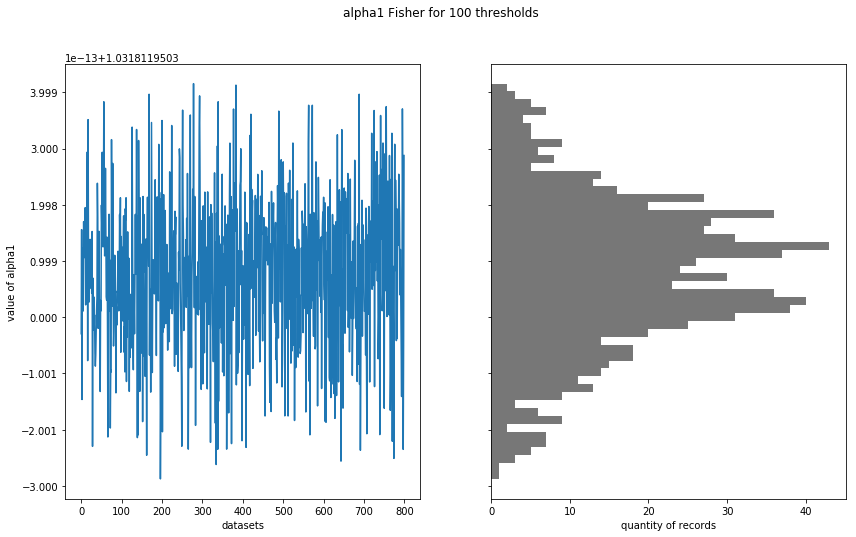

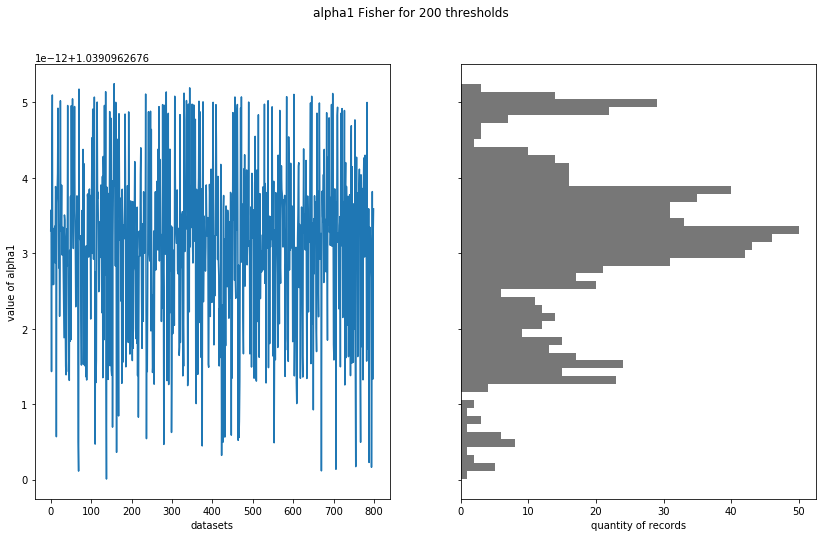

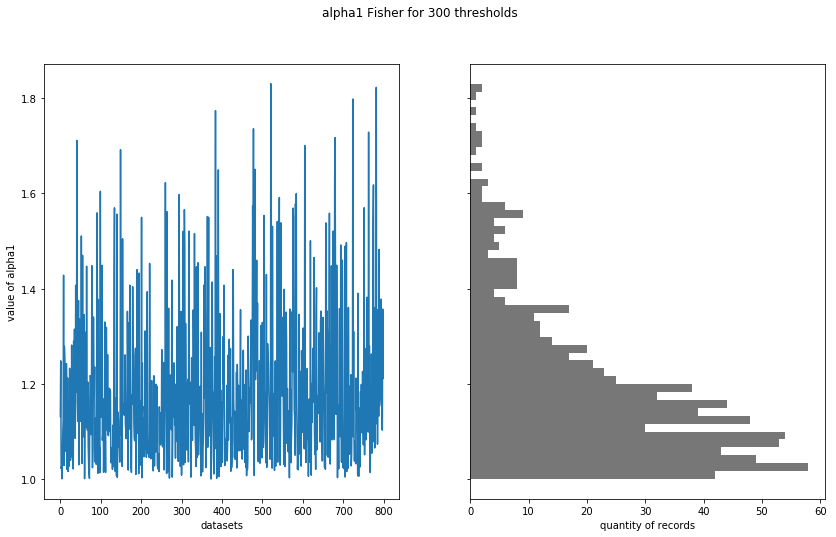

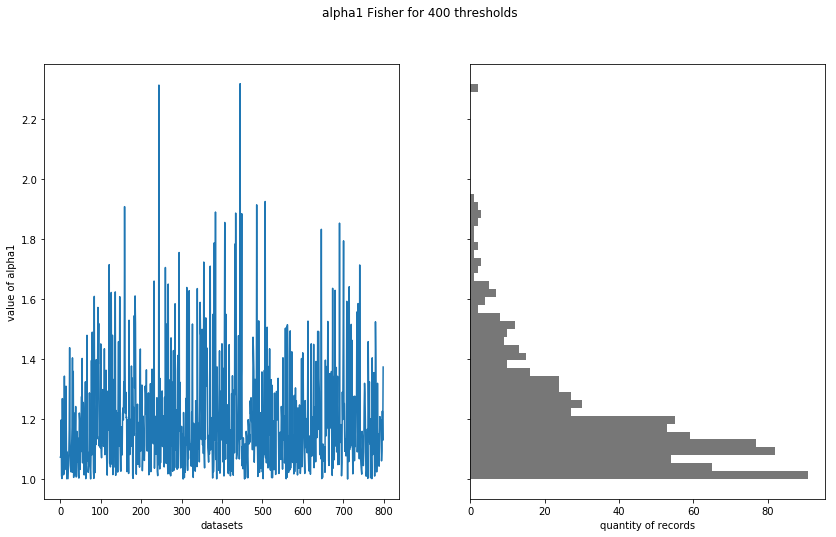

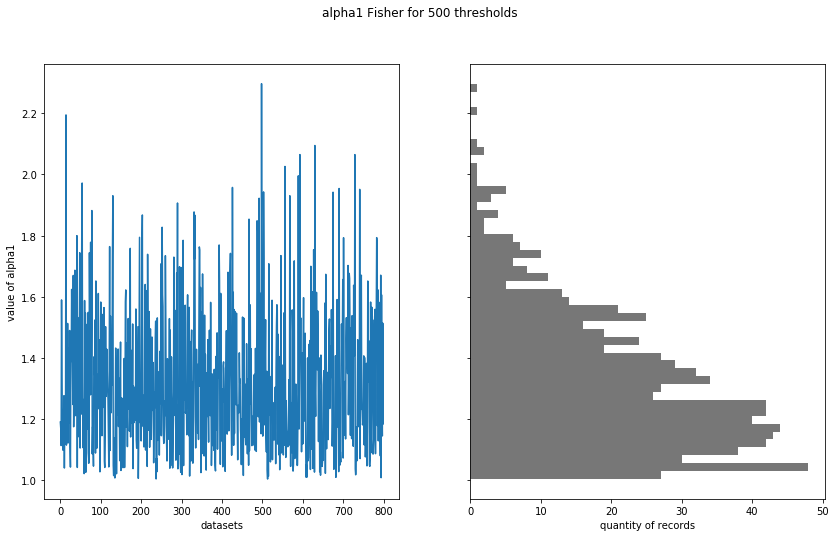

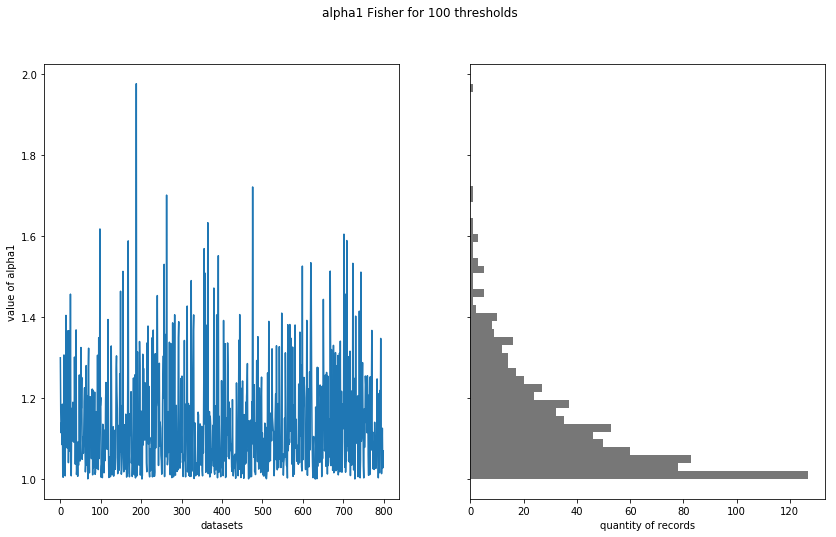

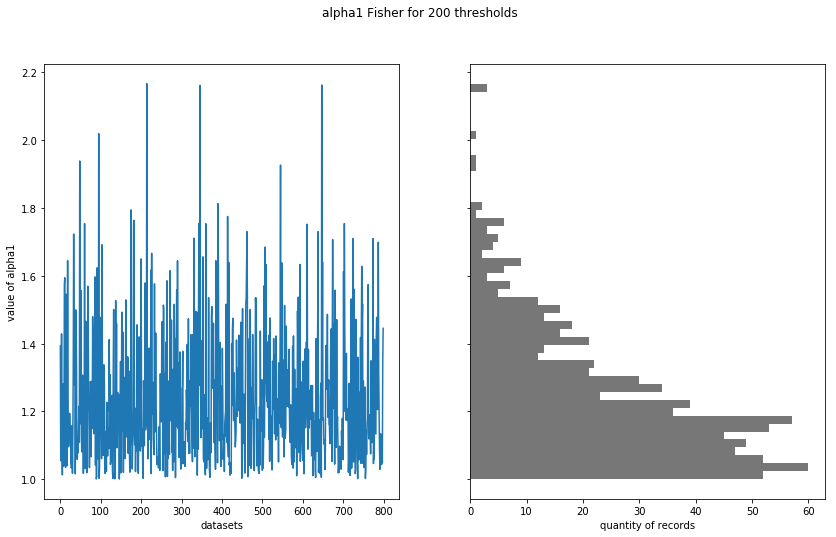

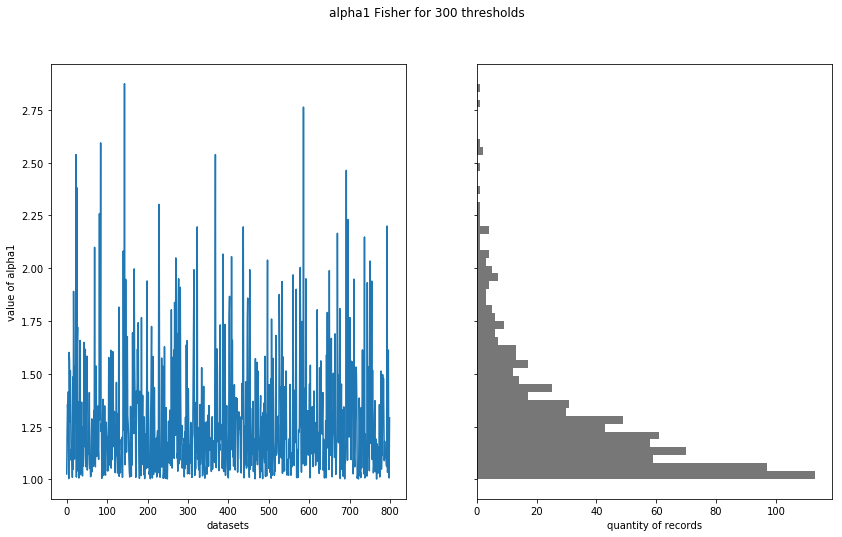

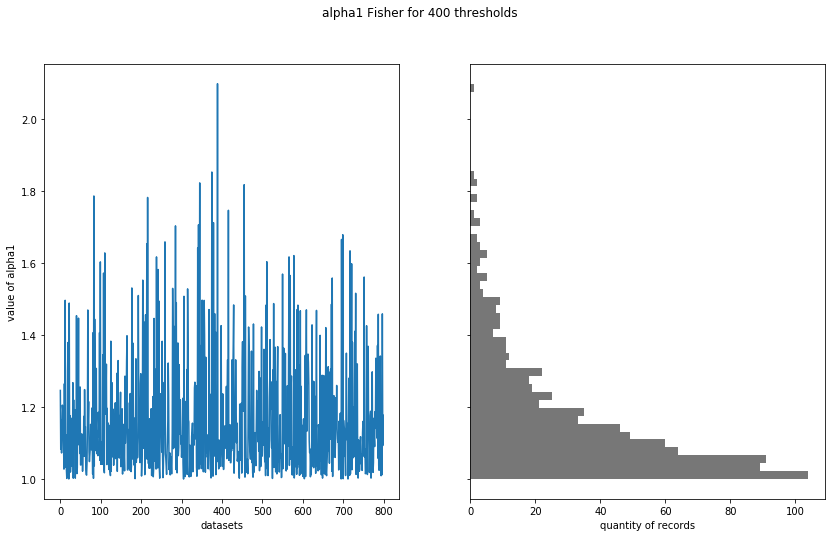

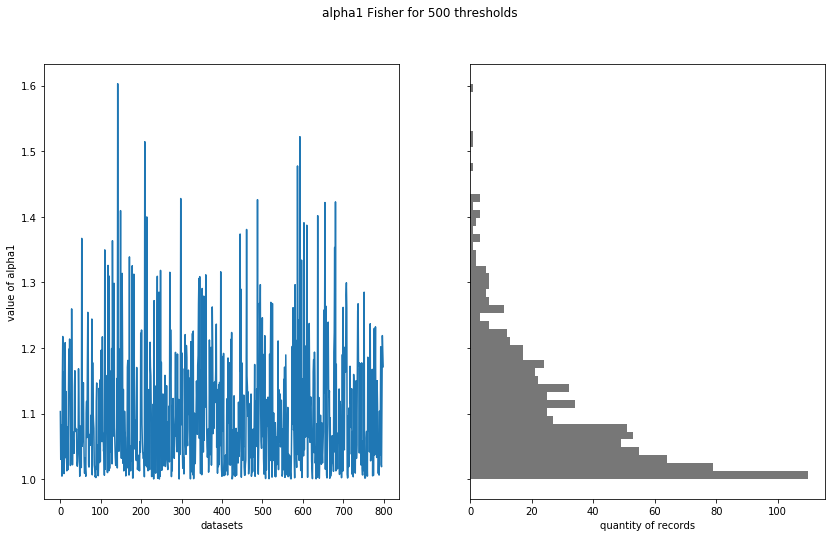

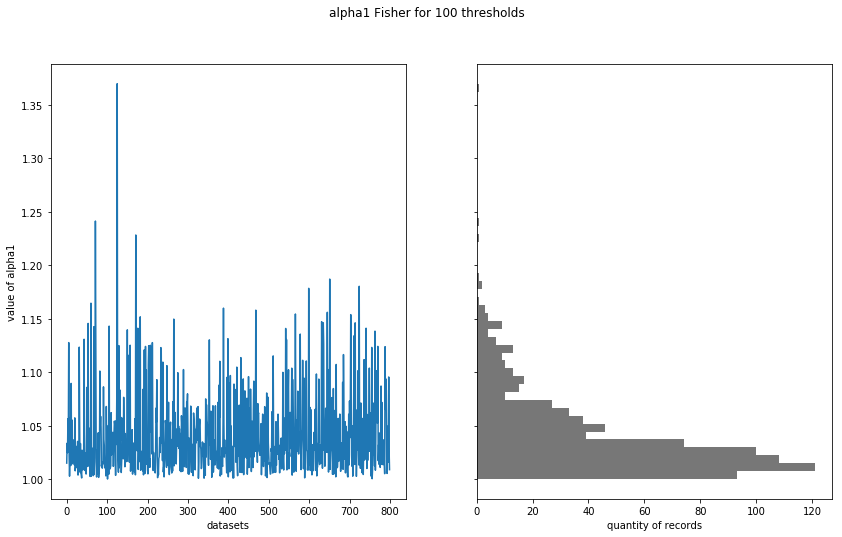

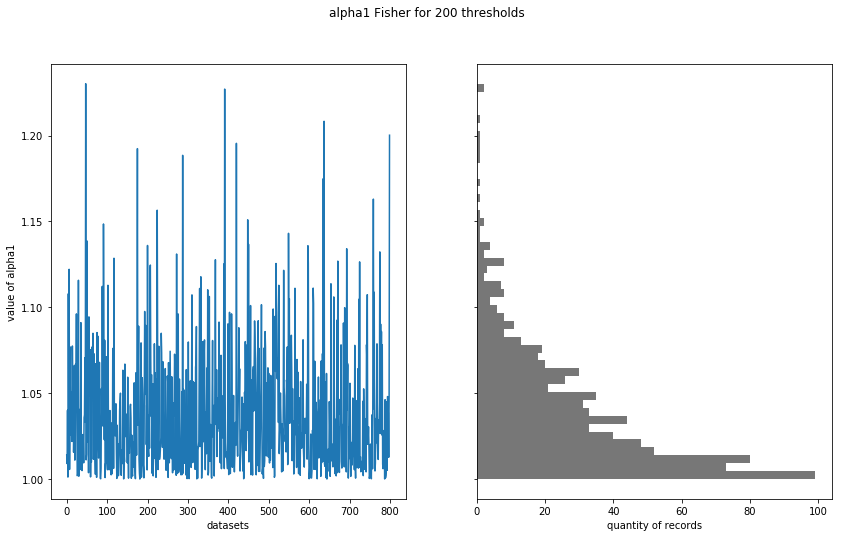

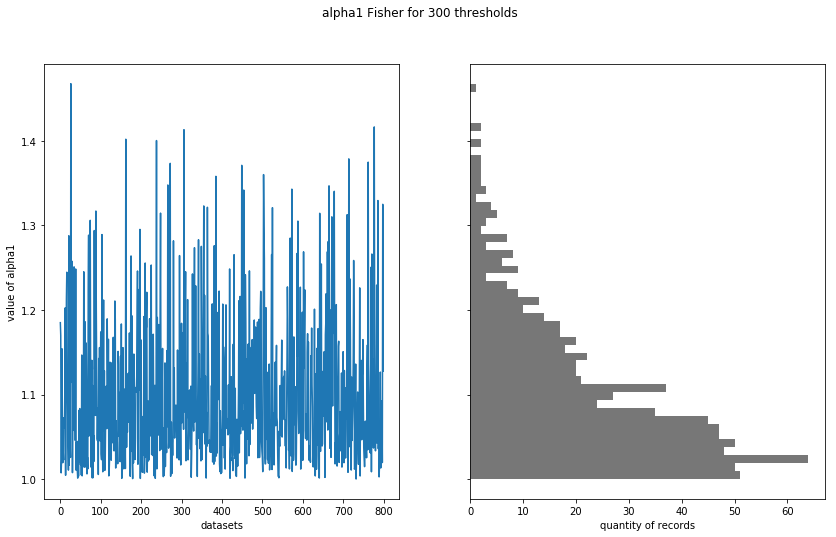

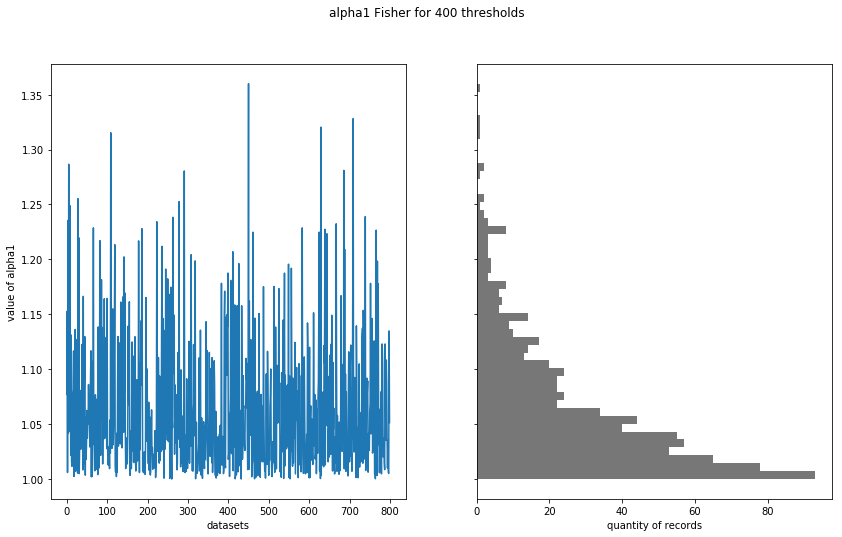

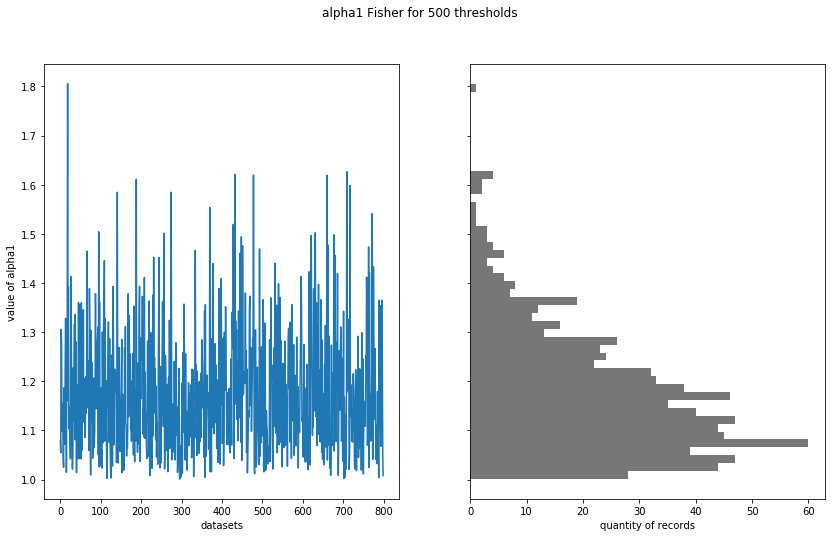

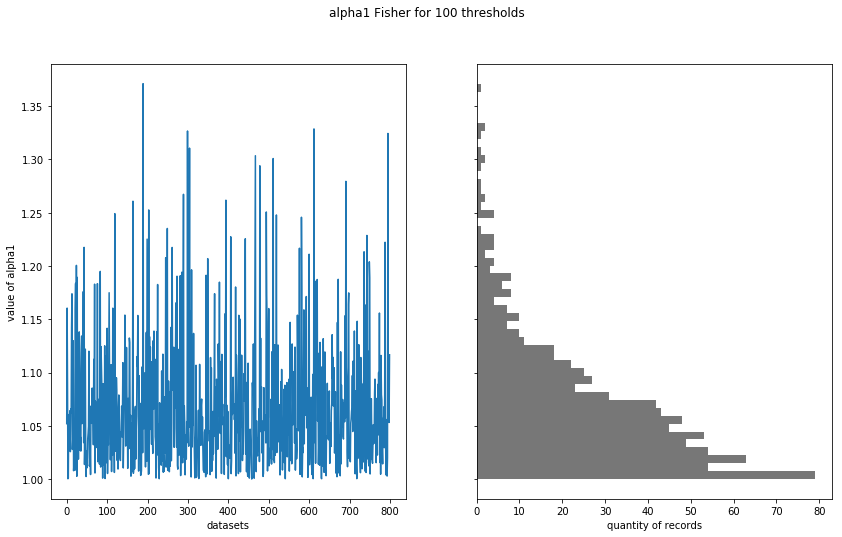

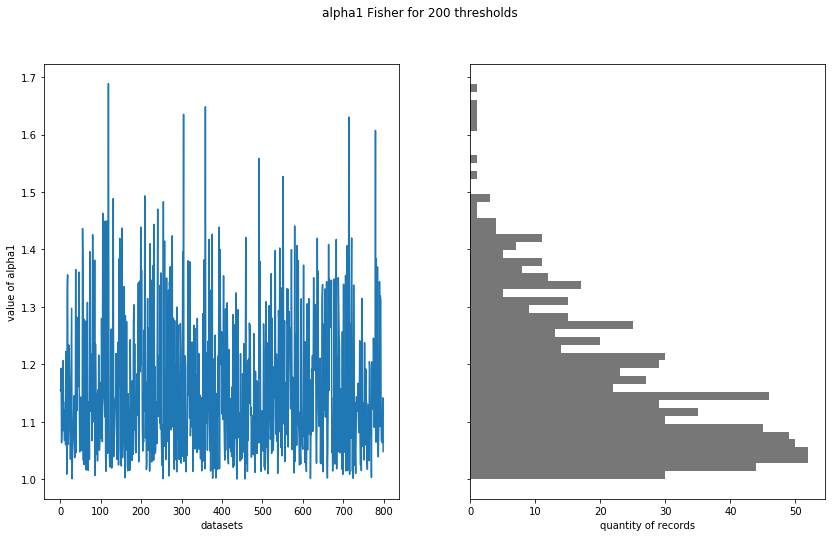

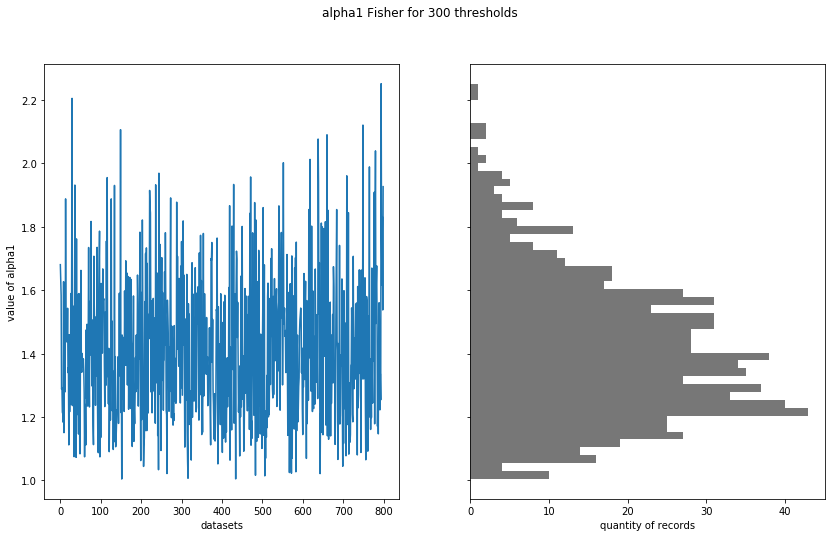

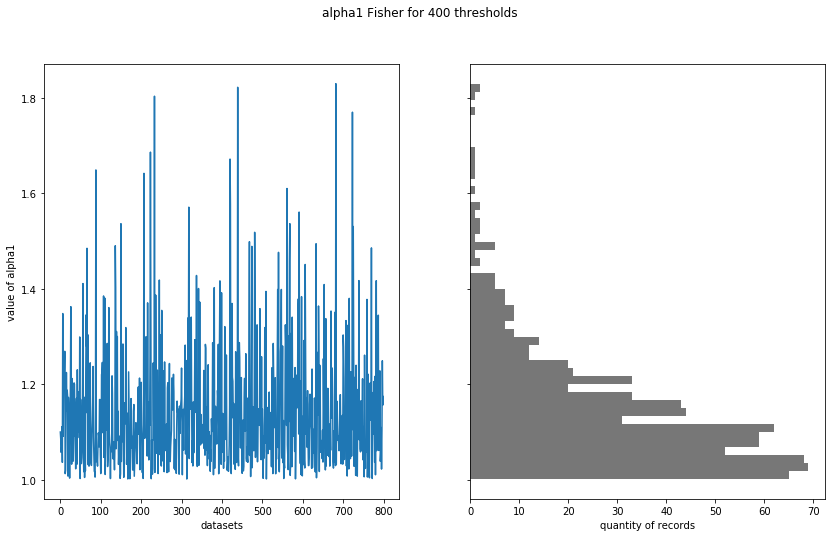

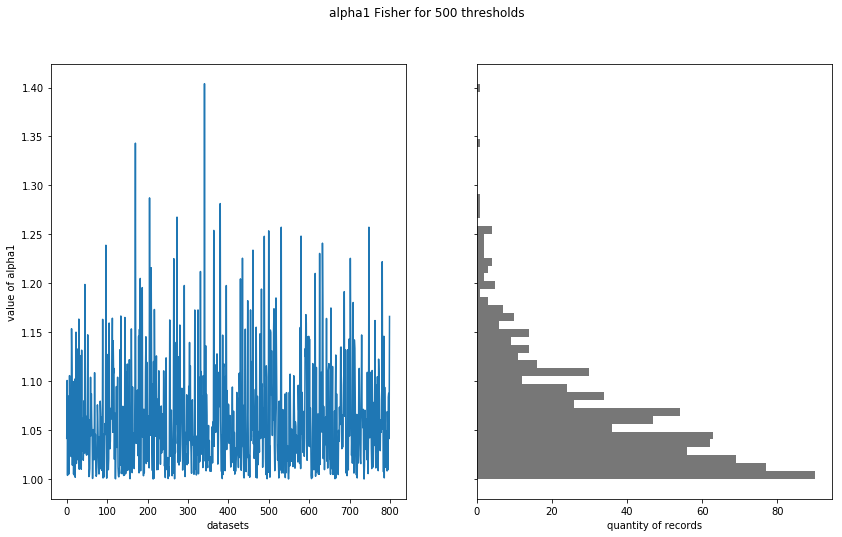

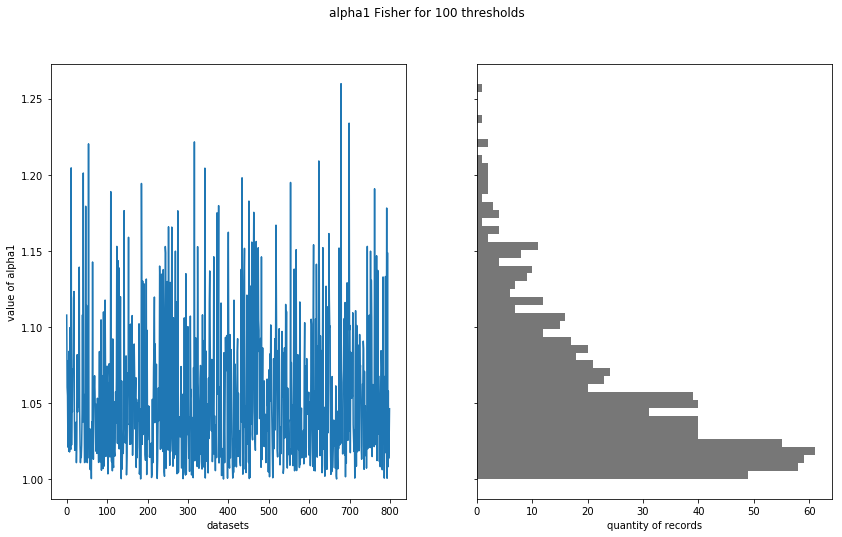

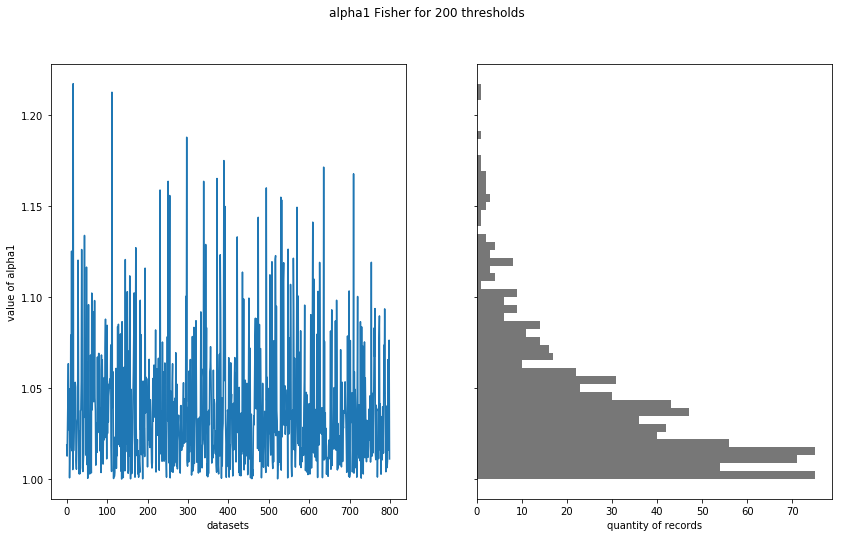

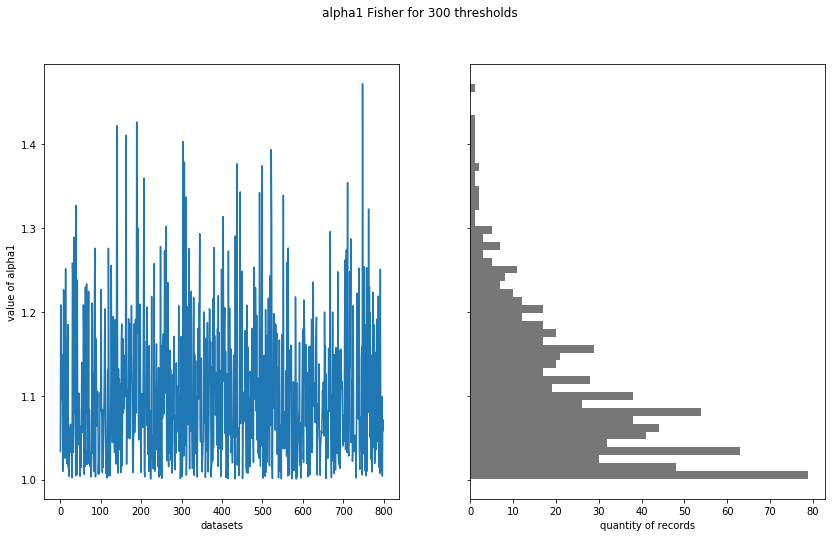

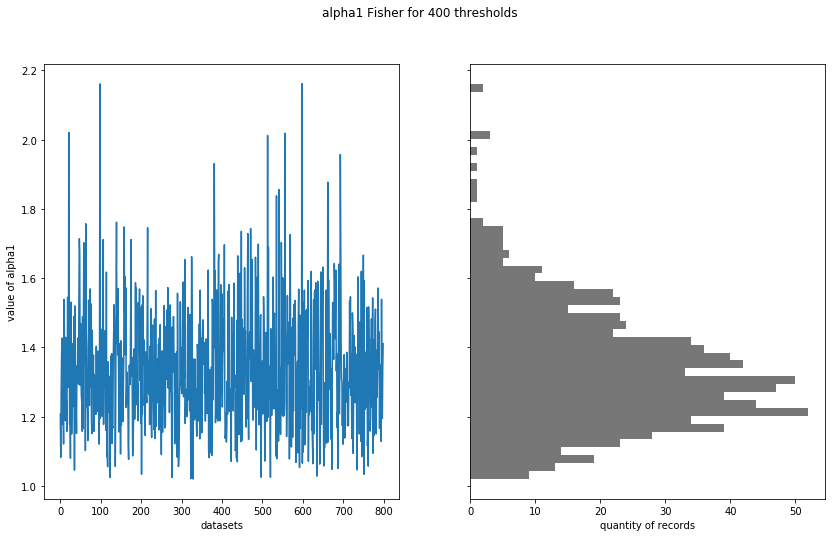

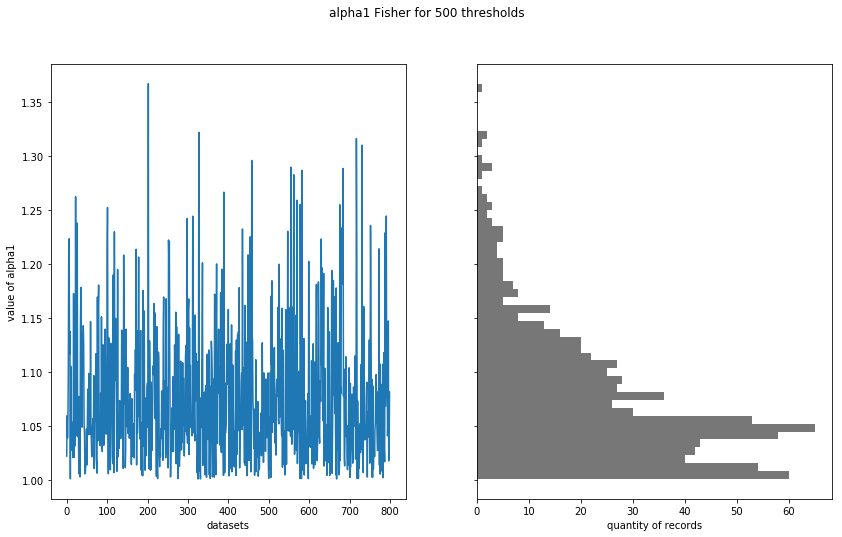

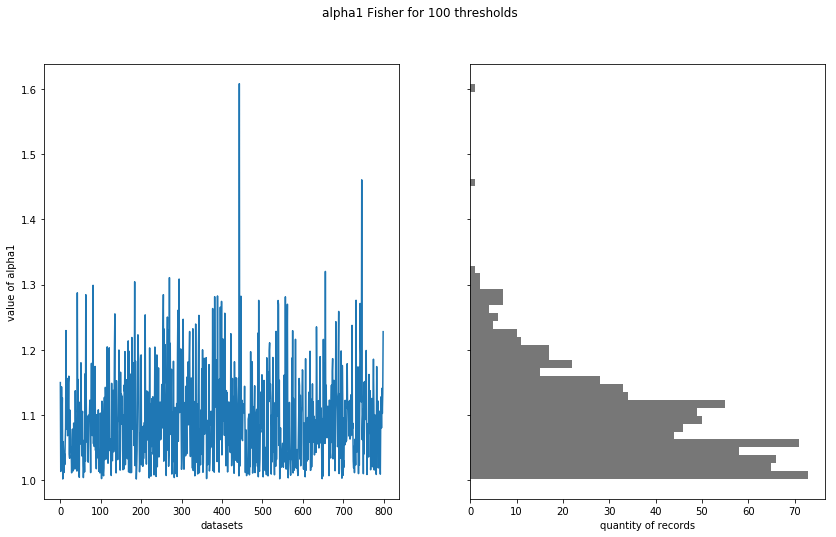

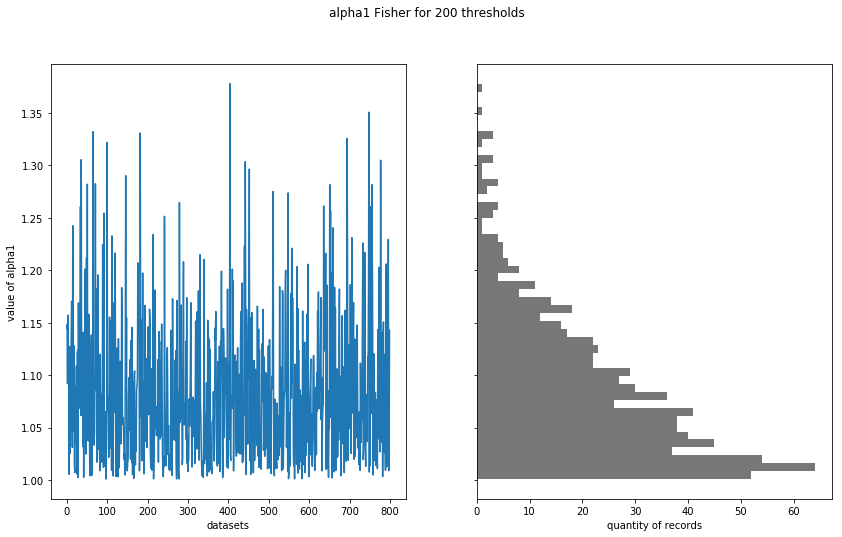

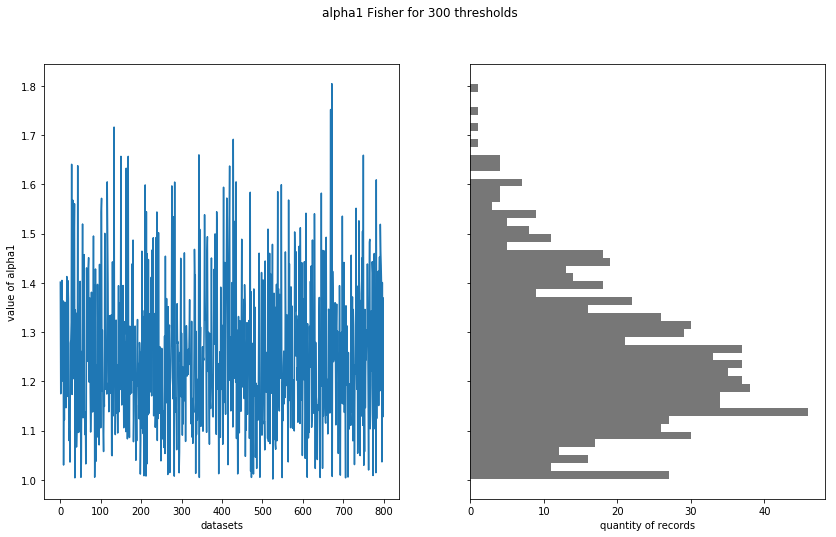

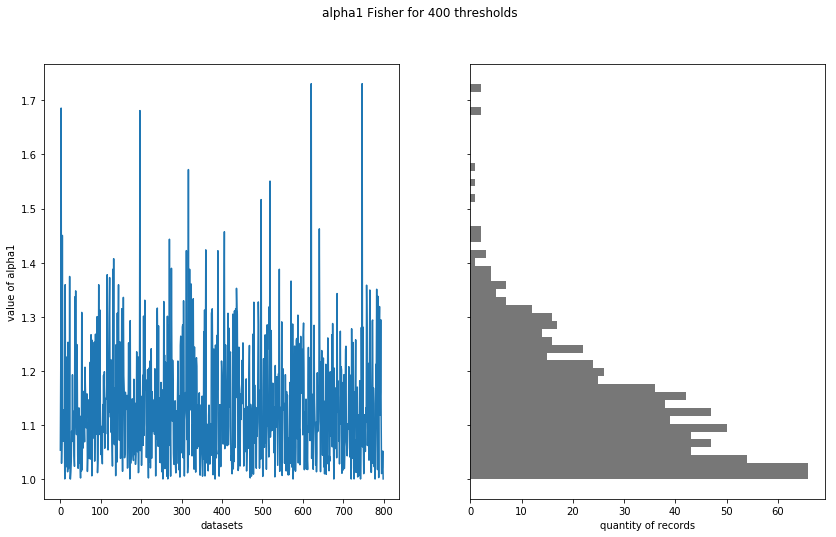

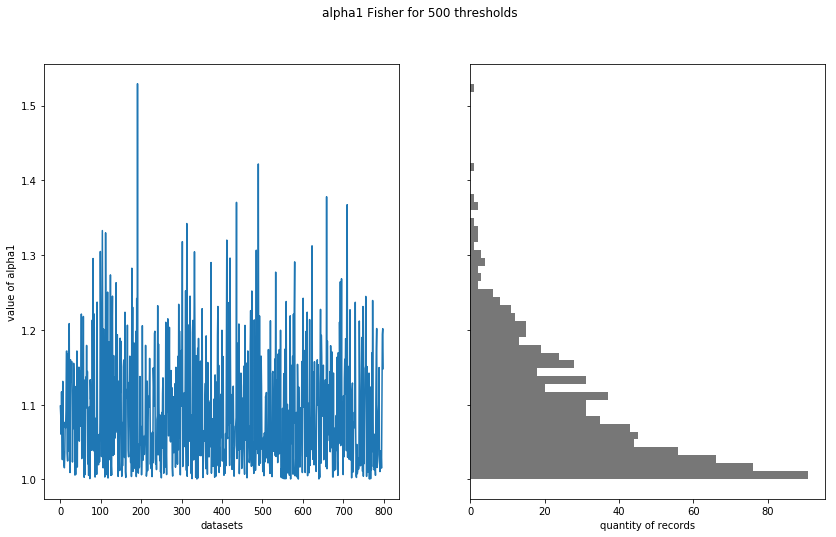

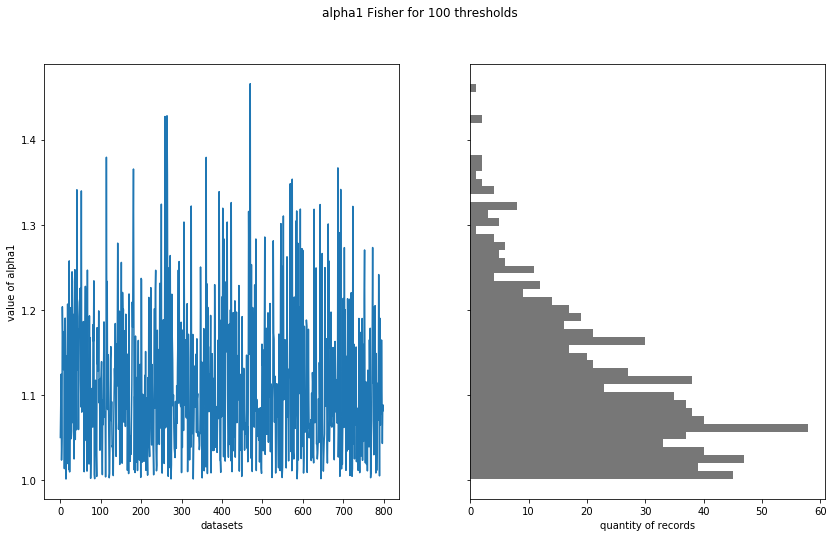

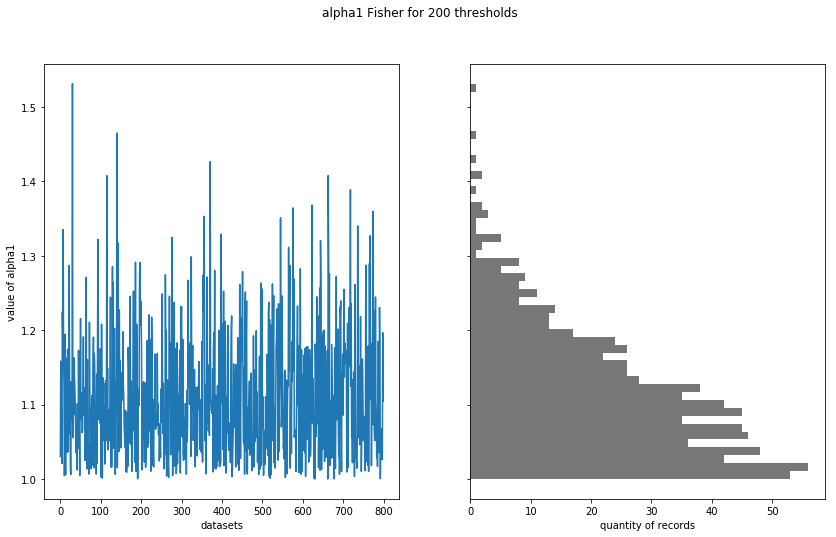

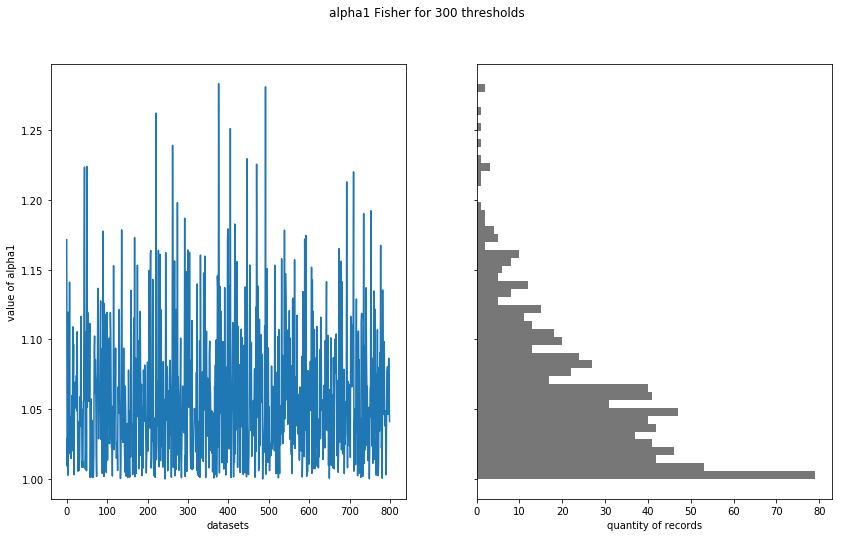

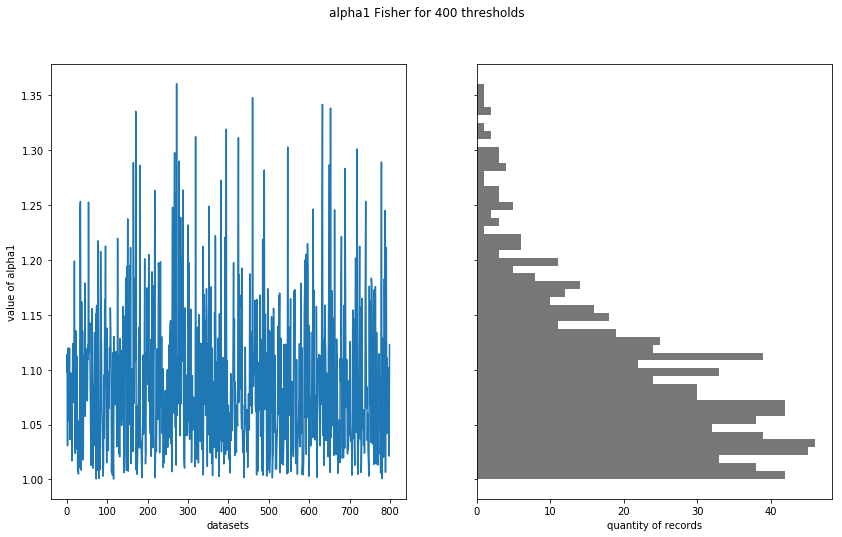

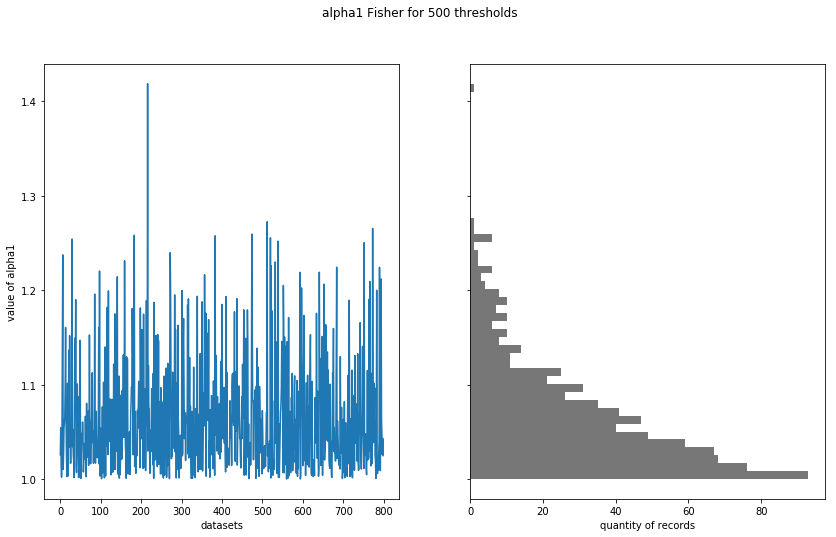

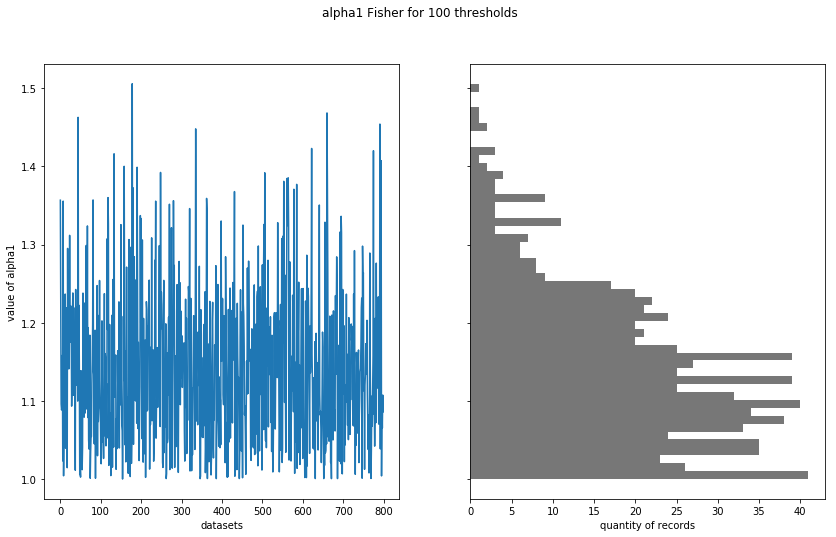

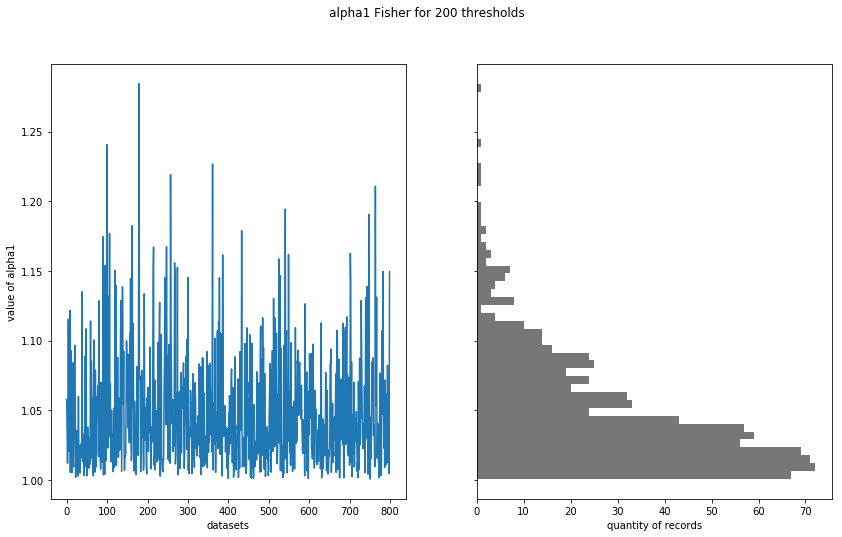

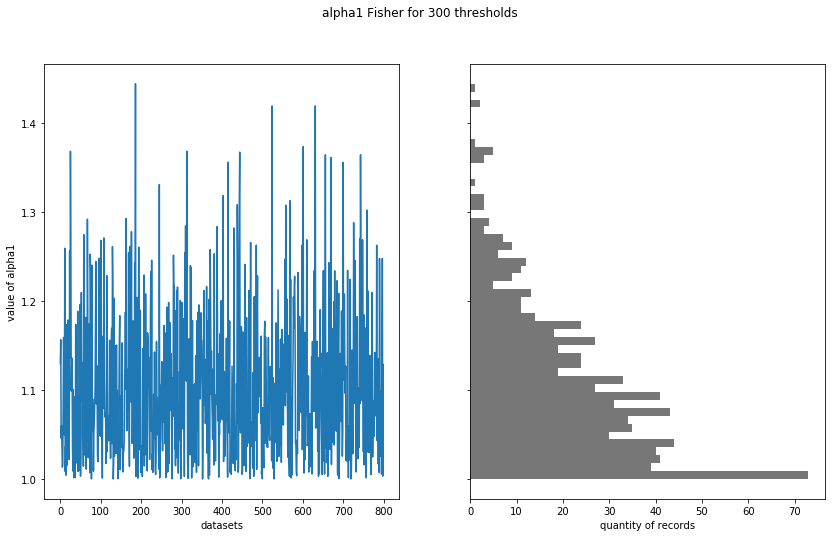

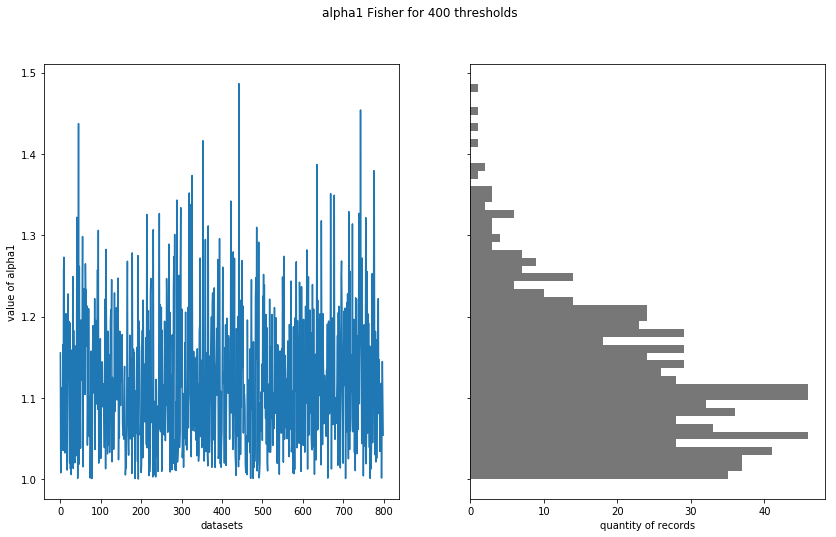

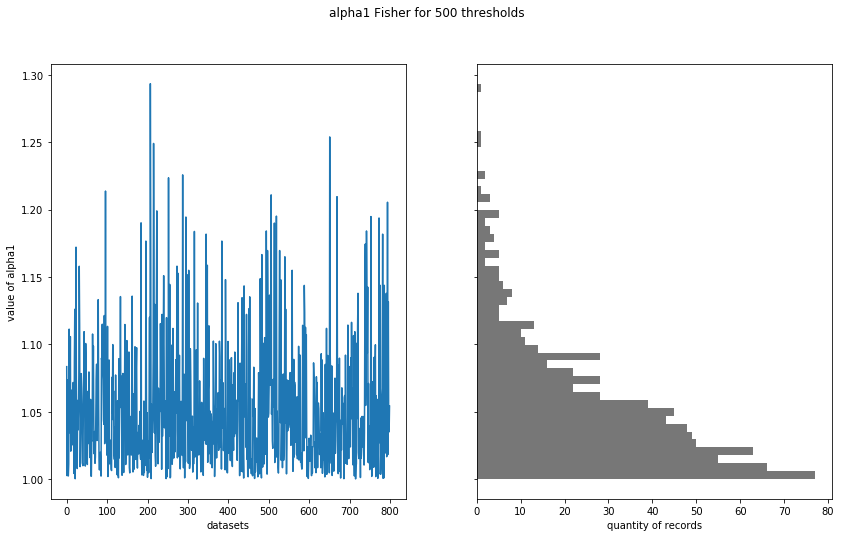

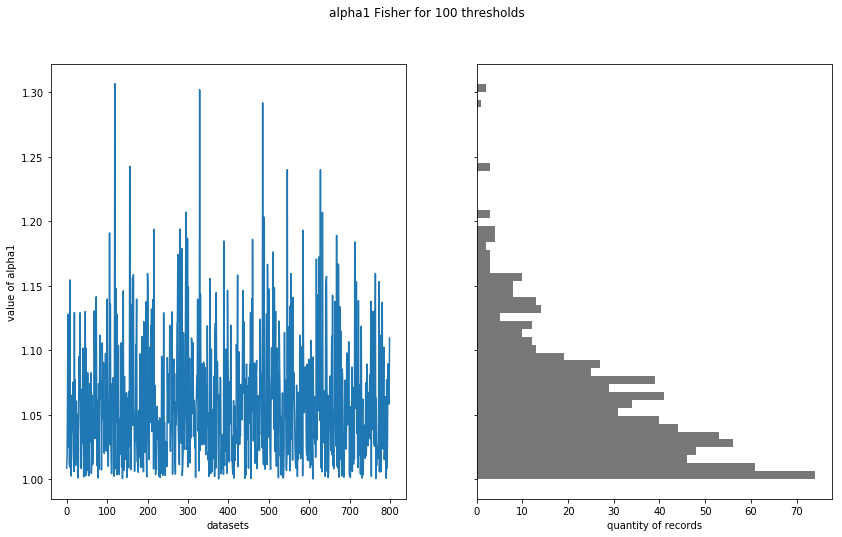

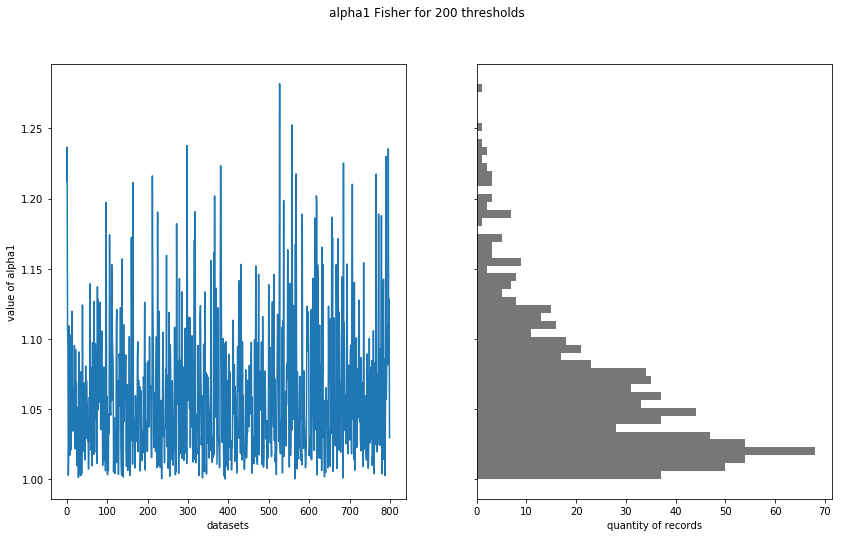

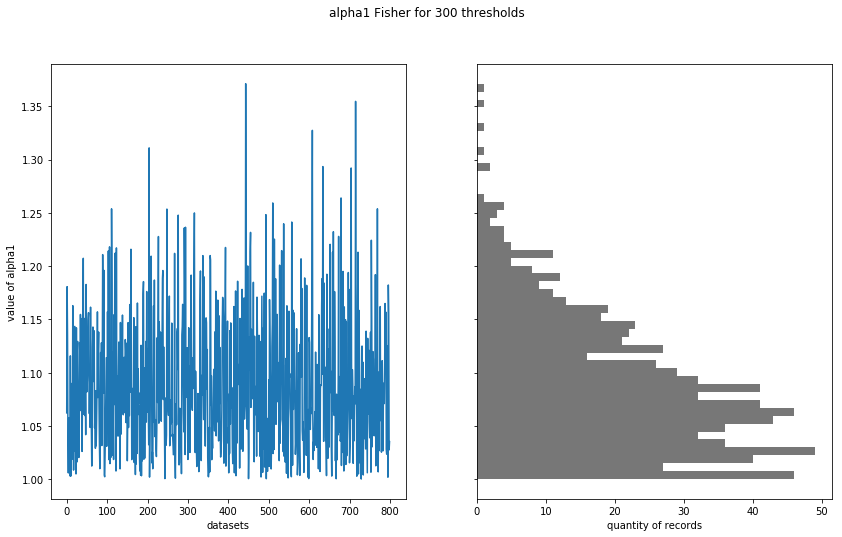

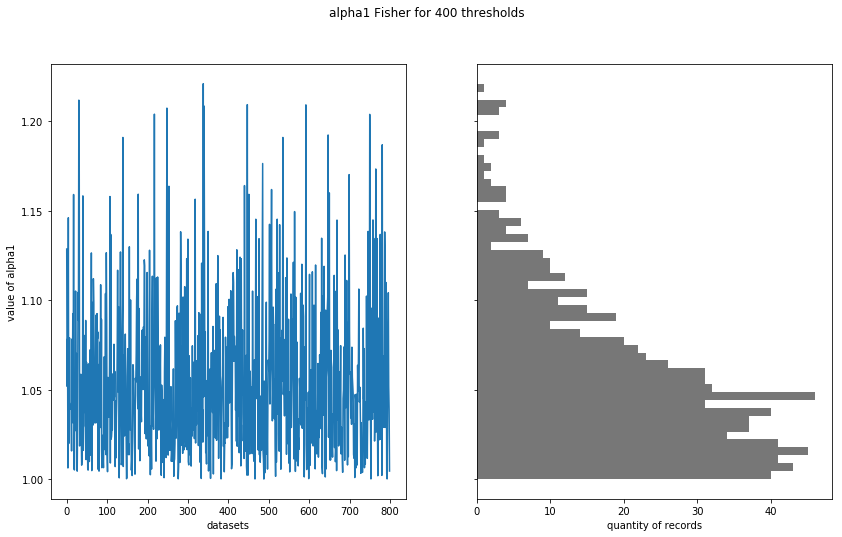

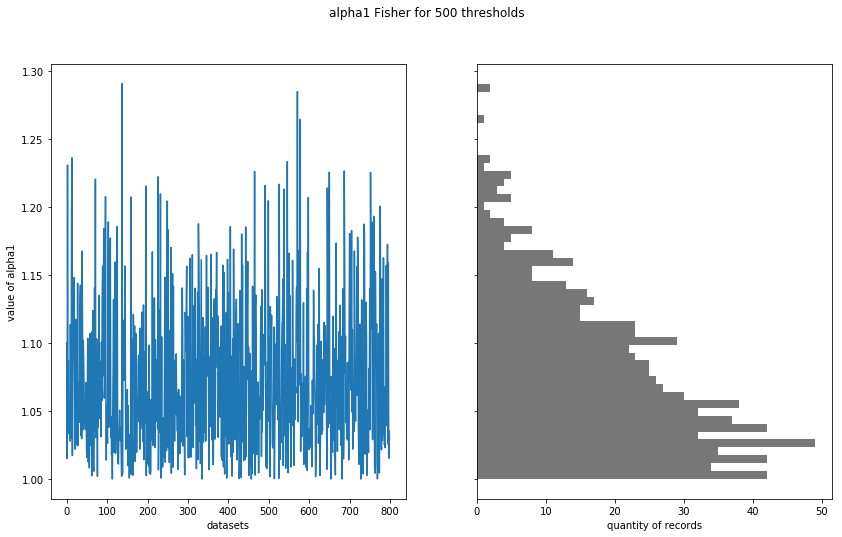

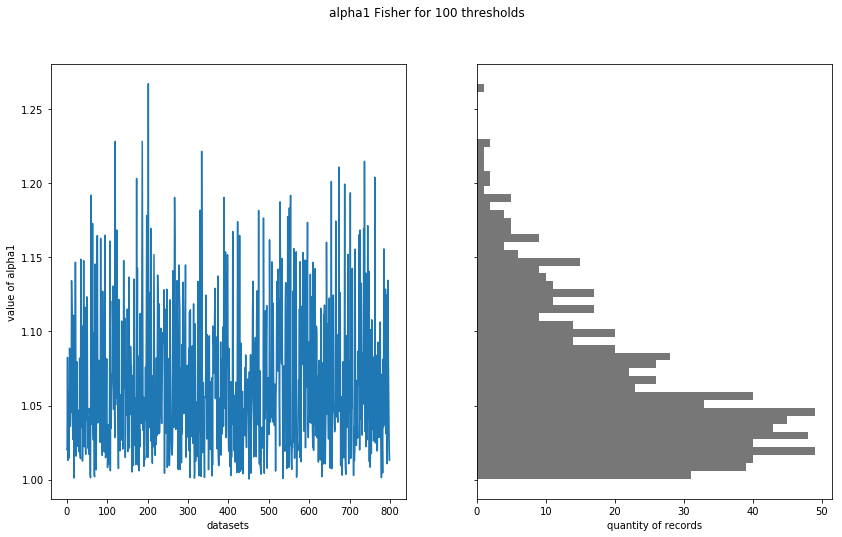

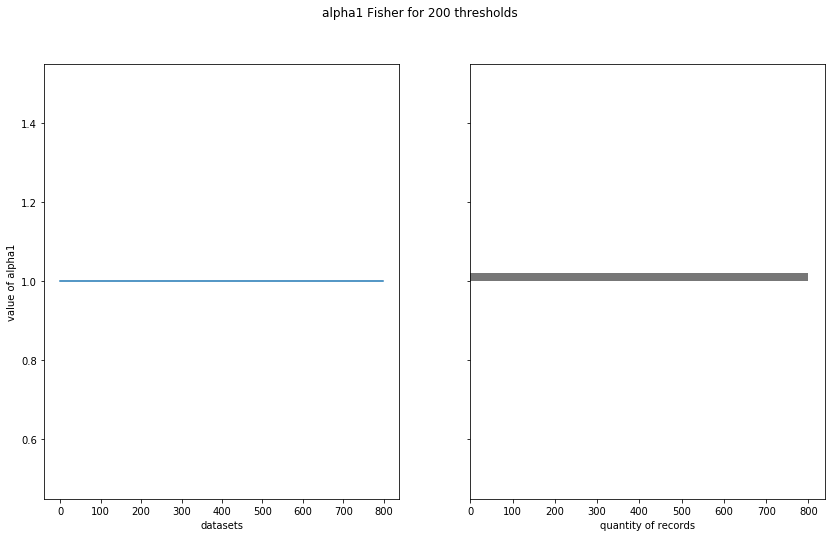

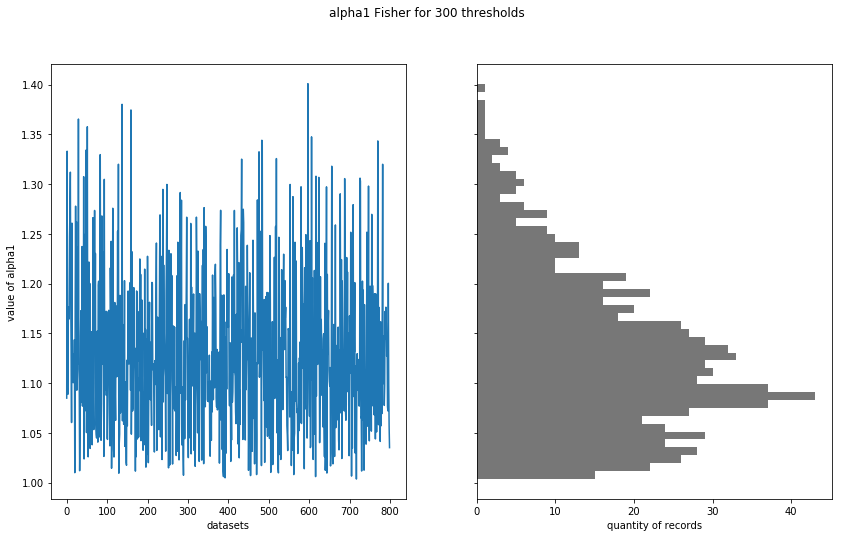

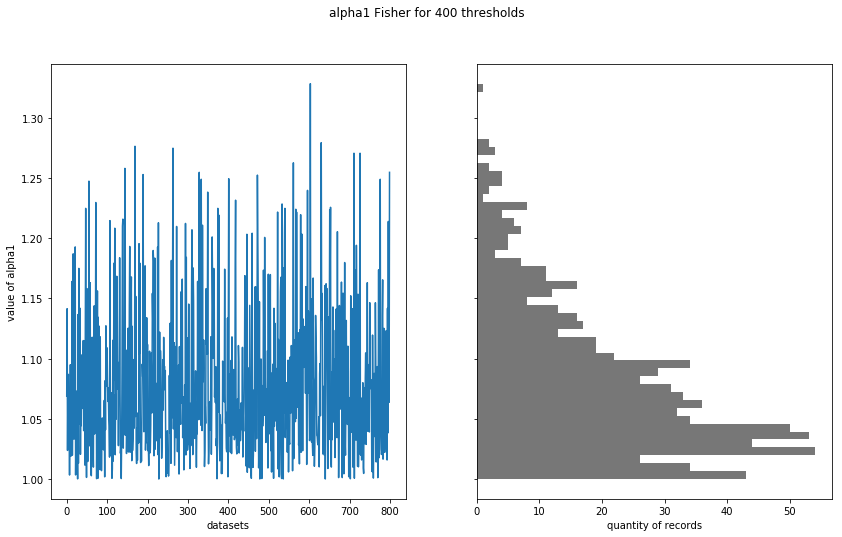

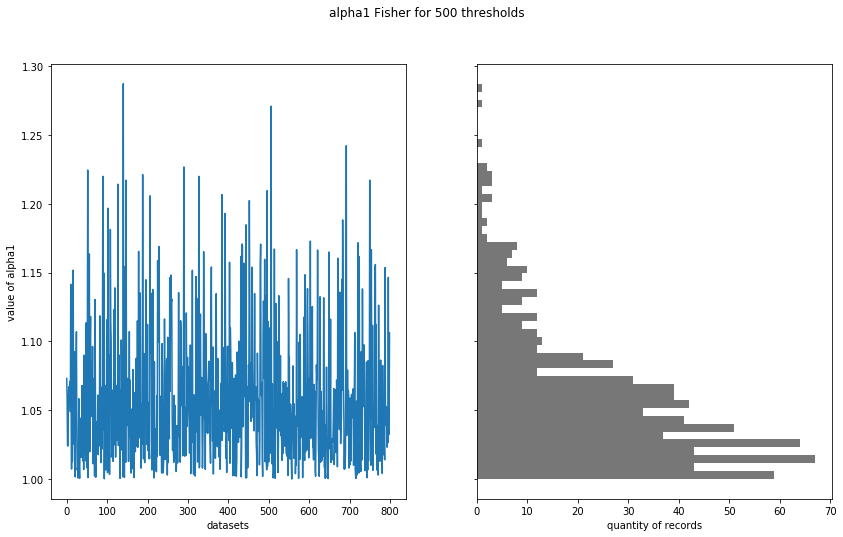

In [14]:
for i in range(n * how_many_different_thresholds):
    plot1(bank_alpha1_traceplots[:,i],  param, distr, jump_excesses[int(i % how_many_different_thresholds)] )


In [15]:
# def median_reshape(A):
#     B = np.zeros(len(q) * how_many_different_thresholds)
#     counter = 0
#     for i in range(len(q)):
#         for j in range(how_many_different_thresholds):
#             B[counter] = np.median(A[i,[x % n == j  for x in range(len(A[0,:]))]] )
#             counter += 1
#     return(B.reshape(len(q), how_many_different_thresholds))

In [16]:
# median_good_shapes_GPD = median_reshape(concatenated_median_quant_BGPD)
# median_good_shapes_Fisher = median_reshape(concatenated_median_quant_BFisher)

In [17]:
# B = np.zeros(len(q) * how_many_different_thresholds)
# counter = 0
# for i in range(len(q)):
#     for j in range(how_many_different_thresholds):
#         B[counter] = np.median(concatenated_median_quant_BGPD[i,[x % n == j  for x in range(len(concatenated_median_quant_BGPD[0,:]))]] )
#         counter += 1
# B = B.reshape(len(q), n)

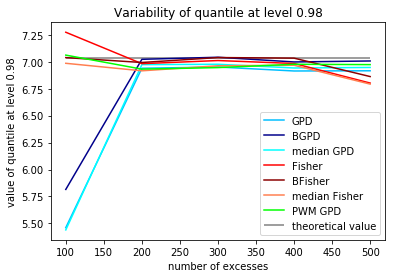

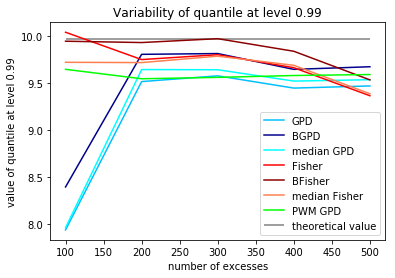

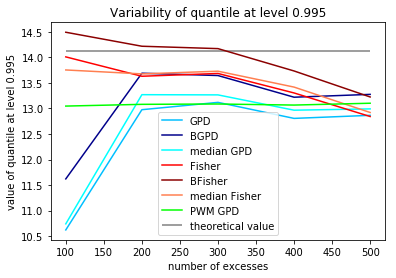

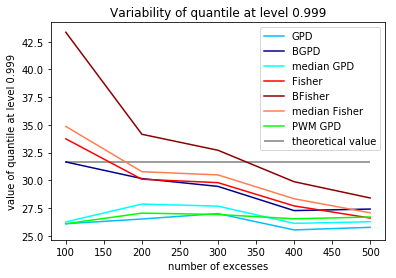

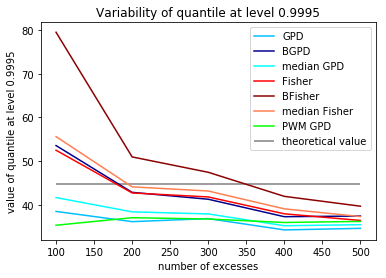

In [18]:
for i in range(len(q)):
    compare_quantiles(jump_excesses,
                  concatenated_averaged_quant_GPD, 
                  concatenated_averaged_bayesian_quant_GPD, 
                  concatenated_averaged_quant_Fisher,
                  concatenated_averaged_bayesian_quant_Fisher,
                  concatenated_median_quant_BGPD,
                  concatenated_median_quant_BFisher, 
                  concatenated_averaged_probability_weighted_moments_GPD,
                  quant_th,
                  i,now)

C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


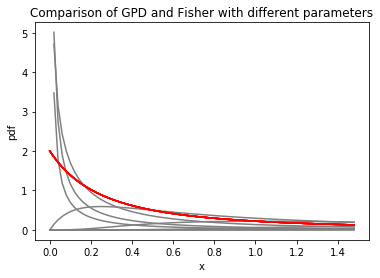

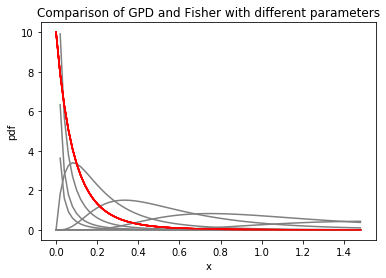

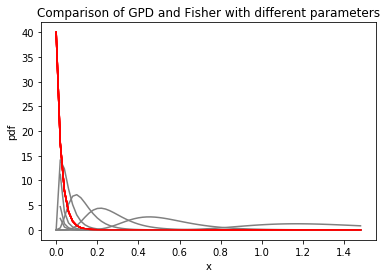

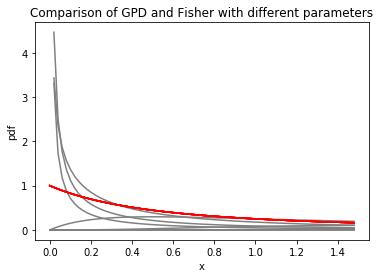

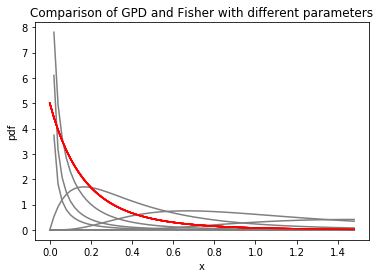

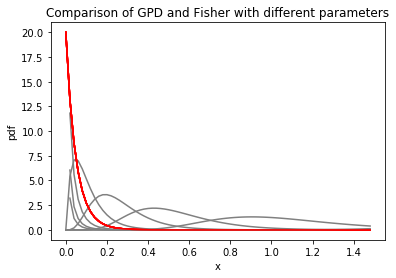

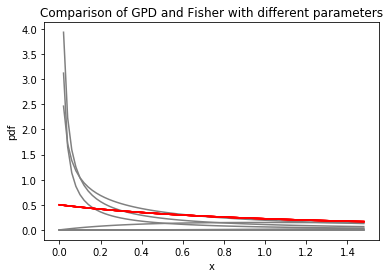

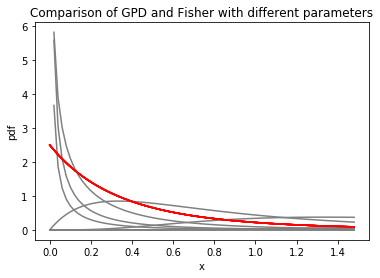

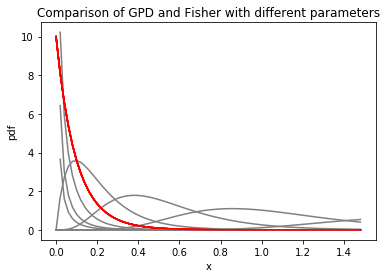

In [19]:
x = np.arange(0,3/2,0.02)
def GPD_pdf(x, alpha, beta):
    return alpha / beta * pow(1 + x / beta , - asarray(alpha)  - 1 )
def Fisher_pdf(x, alpha1, alpha2, beta):
    return 1 / beta / ss.beta(alpha1, alpha2) * pow(x / beta, asarray(alpha1) - 1) / pow(1 + x / beta, asarray(alpha1 + alpha2))

alpha1 = [0.1, 0.2, 1/2,  2, 5, 10, 20, 50]
alpha2 = [1, 5, 20]
beta = [1/2, 1, 2]

for k in range(len(beta)):
    for j in range(len(alpha2)):
        for i in range(len(alpha1)):
            plt.plot(x, Fisher_pdf(x, alpha1[i], alpha2[j], beta[k]), 'gray', label='Fisher_pdf('+ str(alpha1[i]) +','+ str(alpha2[j]) + ', '+ str(beta[k]) + ' )' )
            plt.plot(x, Fisher_pdf(x, 1, alpha2[j], beta[k]), 'red', label='Fisher_pdf('+ str(alpha1[i]) +','+ str(alpha2[j]) + ', '+ str(beta[k]) + ' )' )
        plt.xlabel('x')
        plt.ylabel('pdf')
        plt.title('Comparison of GPD and Fisher with different parameters' )
#         plt.legend()
        # plt.savefig(results_dir + sample_file_name)
        plt.show()
# plt.plot(x, GPD_pdf(x, 1, 1/2),  'mediumblue', label='GPD_pdf(1, 1/2)')
# plt.plot(x, GPD_pdf(x, 1, 1), 'royalblue', label='GPD_pdf(1, 1)') 
# plt.plot(x, GPD_pdf(x, 1, 2), 'midnightblue', label='GPD_pdf(1, 2)')

# plt.plot(x, Fisher_pdf(x, 1/2, 1, 1),  'darkseagreen', label='Fisher_pdf(1/2, 1, 1)') 
# plt.plot(x, Fisher_pdf(x, 1, 1, 1), 'olive', label='Fisher_pdf(1, 1, 1)') 
# plt.plot(x, Fisher_pdf(x, 2, 1, 1), 'darkolivegreen', label='Fisher_pdf(2, 1, 1)') 



In [20]:
#all the parameters ever obtained are in those matrices
list1 = [super_concatenated_probability_weighted_moments_GPD,
        super_concatenated_quant_GPD,
        super_concatenated_bayesian_quant_GPD,
        super_concatenated_quant_Fisher,
        super_concatenated_bayesian_quant_Fisher,
        bank_medians_GPD,
        bank_medians_Fisher ]


In [21]:
for i in range(len(list1)):
    print(shape(list1[i]))

(5, 50)
(5, 50)
(5, 50)
(5, 50)
(5, 50)
(5, 50)
(5, 50)


In [28]:
list1[1,1,1]

TypeError: list indices must be integers or slices, not tuple

In [34]:
B = bank_medians_GPD[0].reshape(n,how_many_different_thresholds)

In [35]:
B

array([[3.21847085, 3.18990813, 7.94505373, 6.67442931, 6.33490961],
       [3.10408022, 6.37409576, 7.06753267, 7.25298725, 3.23393246],
       [7.34189461, 6.83096566, 7.72540305, 6.65652935, 6.26075383],
       [6.71937607, 6.28342827, 7.52413804, 7.32382485, 7.06389489],
       [7.35352984, 6.89687676, 7.62512067, 6.67392584, 6.32130096],
       [6.67430395, 6.31624191, 7.56812376, 7.3194654 , 7.017111  ],
       [7.28413731, 6.78439985, 7.60787337, 6.65959234, 6.30710485],
       [6.6200626 , 6.24756567, 7.54840559, 7.2616598 , 7.10137366],
       [7.3519064 , 6.834486  , 7.5699666 , 6.70006555, 6.32378647],
       [6.68204667, 6.30007342, 7.41019567, 7.17833105, 7.11847517]])

In [36]:
shape(B)

(10, 5)

In [37]:
B[:,0]

array([3.21847085, 3.10408022, 7.34189461, 6.71937607, 7.35352984,
       6.67430395, 7.28413731, 6.6200626 , 7.3519064 , 6.68204667])

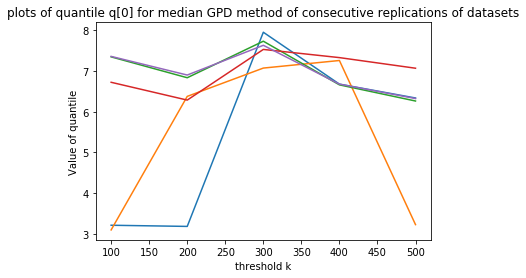

In [42]:
for i in range(how_many_different_thresholds):
    plt.plot(jump_excesses, B[i,:])

plt.xlabel('threshold k')
plt.ylabel('Value of quantile')
plt.title('plots of quantile q[0] for median GPD method of consecutive replications of datasets' )

plt.show()